In [ ]:
# =============================================================================
# CELL 1 — IMPORTS & CONFIG
# =============================================================================

import os
import re
import json
import time
import shutil
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import cv2
from tqdm.auto import tqdm
from dotenv import load_dotenv

import whisper
from apify_client import ApifyClient

# Your existing helpers / models
from mine_redis import get_files_gem  # SAME helper as in your notebooks
from aesthetic_predictor import predict_aesthetic  # used in attractiveness
# from ultralytics import YOLO  # if you use YOLO for accessories, uncomment

load_dotenv()

GEMINI_API_KEY=os.getenv("GEMINI_API_KEY")
APIFY_API_KEY=os.getenv("APIFY_API_TOKEN")

from concurrent.futures import ThreadPoolExecutor, as_completed

MAX_DOWNLOAD_WORKERS = 10


if not APIFY_API_KEY:
    raise RuntimeError("Missing APIFY_API_KEY in env/.env")

apify = ApifyClient(APIFY_API_KEY)

# If you use Gemini
from google import genai
gemini_client = genai.Client(api_key=GEMINI_API_KEY) if GEMINI_API_KEY else None
GEMINI_MODEL = "models/gemini-2.0-flash-001"

# -------------------------------------------------------------------------
# GLOBAL CONFIG
# -------------------------------------------------------------------------

REEL_DOWNLOAD_DIR = "./_reel_cache"
os.makedirs(REEL_DOWNLOAD_DIR, exist_ok=True)

MAX_REELS_PER_CREATOR = 1 # you can tune
FRAME_SAMPLE_COUNT = 16    # frames per reel for vision metrics

import torch

USE_GPU = torch.cuda.is_available()
DEVICE = "cuda" if USE_GPU else "cpu"

print(f"Using device: {DEVICE}")


DEVICE = "cuda" if (hasattr(whisper, "cuda") and torch.cuda.is_available()) else "cpu"
print("Using device:", DEVICE)


c:\Users\gaura\Desktop\creator-scorer\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Using device: cpu


In [4]:
import json
import os
from pathlib import Path

CACHE_PATH = Path("reel_manifest.json")

def load_manifest():
    if CACHE_PATH.exists():
        with open(CACHE_PATH, "r", encoding="utf-8") as f:
            return json.load(f)
    return {}

def save_manifest(manifest):
    with open(CACHE_PATH, "w", encoding="utf-8") as f:
        json.dump(manifest, f, indent=2)

manifest = load_manifest()


In [5]:
# =============================================================================
# APIFY CLIENT + SCRAPER HELPERS — MATCHING gemini.ipynb
# =============================================================================

import os
import pandas as pd
from dotenv import load_dotenv
from apify_client import ApifyClient

from mine_redis import get_files_gem  # same helper you use elsewhere

load_dotenv()

# APIFY_API_KEY = os.getenv("APIFY_API_KEY")
if not APIFY_API_KEY:
    raise RuntimeError("Missing APIFY_API_KEY (set it in .env or env vars)")

# Single Apify client (same as in gemini.ipynb)
apify = ApifyClient(APIFY_API_KEY)


def flatten_comments(comment_list, max_n: int = 50) -> list[str]:
    """
    Convert a single comment list (Apify objects) → simple text list.
    Used as a primitive for both top-level and deep comment arrays.
    """
    if not isinstance(comment_list, list):
        return []
    out = []
    for c in comment_list[:max_n]:
        if isinstance(c, dict):
            txt = c.get("text") or c.get("body") or ""
            txt = (txt or "").strip()
            if txt:
                out.append(txt)
    return out

from pathlib import Path

APIFY_CACHE_DIR = Path("cache_apify")
APIFY_CACHE_DIR.mkdir(parents=True, exist_ok=True)

def load_or_fetch_reels_cached(creator: str, max_items: int) -> pd.DataFrame:
    """
    Cache wrapper around fetch_reels_from_apify.

    - First run: hits Apify, saves to cache_apify/<creator>_max<max_items>.parquet
    - Re-runs: loads from that file instead of hitting the network.
    """
    cache_path = APIFY_CACHE_DIR / f"{creator}_max{max_items}.parquet"

    if cache_path.exists():
        print(f"📂 Using cached Apify reels for @{creator} from {cache_path}")
        return pd.read_parquet(cache_path)

    # Fallback: real network call once
    df = fetch_reels_from_apify(creator, max_items=max_items)
    if not df.empty:
        df.to_parquet(cache_path, index=False)
        print(f"💾 Cached Apify reels for @{creator} → {cache_path}")
    else:
        print(f"⚠️ No reels for @{creator}, nothing cached.")
    return df



import time
from contextlib import contextmanager
import pandas as pd

def fetch_reels_from_apify(handle: str, max_items: int = MAX_REELS_PER_CREATOR) -> pd.DataFrame:
    """
    NO-CACHE reels fetch.

    Timing components recorded (if `record(...)` exists):
      - apify.actor.call
      - apify.dataset.list_items
      - items_to_df
      - normalize_fields
      - flatten_comments
      - url_filter
    """
    print(f"\n📸 Fetching reels for @{handle} via Apify...")

    @contextmanager
    def _t(name: str, **meta):
        t0 = time.perf_counter()
        try:
            yield
        finally:
            dt = time.perf_counter() - t0
            if "record" in globals() and callable(globals()["record"]):
                globals()["record"]("api_component", name, dt, creator=handle, **meta)

    try:
        run_input = {
            "username": [handle],
            "resultsLimit": int(max_items),
            # Ensure your Apify actor input supports comments:
            # "scrapeComments": True,
            # "scrapeDeepComments": True,
        }

        with _t("apify.actor.call", actor_id="xMc5Ga1oCONPmWJIa"):
            run = apify.actor("xMc5Ga1oCONPmWJIa").call(run_input=run_input)

        dataset_id = run.get("defaultDatasetId")
        if not dataset_id:
            print("  ✗ Missing defaultDatasetId from Apify run.")
            return pd.DataFrame()

        with _t("apify.dataset.list_items", dataset_id=dataset_id):
            items = apify.dataset(dataset_id).list_items().items

        if not items:
            print("  ✗ No items returned.")
            return pd.DataFrame()

        with _t("items_to_df"):
            df = pd.DataFrame(items)

        with _t("normalize_fields"):
            # ----------------- reel_url -----------------
            if "url" in df.columns:
                df["reel_url"] = df["url"]
            elif "shortcode" in df.columns:
                df["reel_url"] = "https://www.instagram.com/reel/" + df["shortcode"].astype(str) + "/"
            else:
                df["reel_url"] = None

            # ----------------- caption ------------------
            if "caption" in df.columns:
                df["caption_norm"] = df["caption"].fillna("")
            else:
                df["caption_norm"] = ""

        # ----------------- comments (including deep) ------------------
        # These are the fields Apify IG actors typically expose when deep comments are enabled.
        comment_fields = [
            "latestComments",        # top-level
            "comments",              # alt top-level
            "deepLatestComments",    # replies / threaded
            "deepComments",          # alt deep field
        ]
        comment_fields = [c for c in comment_fields if c in df.columns]

        with _t("flatten_comments", fields=",".join(comment_fields) if comment_fields else ""):
            if comment_fields:
                def collect_all_comments(row, max_total=100):
                    texts = []
                    for col in comment_fields:
                        texts.extend(flatten_comments(row.get(col), max_n=50))
                    # de-duplicate while preserving order
                    seen, uniq = set(), []
                    for t in texts:
                        if t and t not in seen:
                            seen.add(t)
                            uniq.append(t)
                        if len(uniq) >= max_total:
                            break
                    return uniq

                df["flat_comments"] = df.apply(collect_all_comments, axis=1)
            else:
                df["flat_comments"] = [[] for _ in range(len(df))]

        with _t("url_filter"):
            mask = (
                df["reel_url"].notna()
                & (
                    df["reel_url"].astype(str).str.contains("/reel/", na=False)
                    | df["reel_url"].astype(str).str.contains("/p/", na=False)
                )
            )

        out = df.loc[mask, ["reel_url", "caption_norm", "flat_comments"]].copy()
        out = out.rename(columns={"caption_norm": "caption"}).reset_index(drop=True)

        print(f"  ✓ {len(out)} valid reels for @{handle}")
        return out

    except Exception as e:
        print(f"  ✗ Apify error for @{handle}: {e}")
        return pd.DataFrame()

# -----------------------------------------------------------------------------
# DOWNLOAD CACHING (your previous logic is basically fine)
# -----------------------------------------------------------------------------

_download_cache = {}   # reel_url -> local_path

def download_reel_cached(reel_url: str, reel_no: int, task_id: str = "joint") -> str | None:
    """
    Wrapper around get_files_gem so we only hit your reel downloader ONCE per URL.
    Mirrors the pattern used in the other notebooks.
    """
    if reel_url in _download_cache:
        return _download_cache[reel_url]

    # out = get_files_gem(REEL_URL=reel_url, REEL_NO=str(reel_no), task_id=task_id)
    # if not out:
    #     return None

    # # get_files_gem may return a path or a dict with 'path'
    # if isinstance(out, dict):
    #     path = out.get("path")
    # else:
    #     path = out

    # if not path or not os.path.exists(path):
    #     return None

    # local_path = os.path.abspath(path)
    # _download_cache[reel_url] = local_path
    # return local_path


In [6]:
# =============================================================================
# ATTRACTIVENESS MODULE (standalone)
# =============================================================================

import os
import math
from typing import List, Tuple, Dict, Optional
from aesthetic_predictor import predict_aesthetic

import cv2
import numpy as np
from PIL import Image
from dataclasses import dataclass


# How many frames to sample per reel for attractiveness
FRAMES_PER_REEL = 16


# -----------------------------------------------------------------------------
# 1. FRAME SAMPLING
# -----------------------------------------------------------------------------
def sample_frames_from_video(video_path: str, max_frames: int = FRAMES_PER_REEL) -> List[np.ndarray]:
    """
    Uniformly sample up to `max_frames` frames from a video.

    Returns a list of frames in BGR (OpenCV default).
    """
    if not os.path.exists(video_path):
        return []

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
    if total_frames == 0:
        cap.release()
        return []

    # Choose indices uniformly across the video
    indices = np.linspace(0, total_frames - 1, num=min(max_frames, total_frames), dtype=int)
    indices_set = set(indices.tolist())

    frames = []
    idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if idx in indices_set:
            frames.append(frame)
        idx += 1

    cap.release()
    return frames


# -----------------------------------------------------------------------------
# 2. FACE DETECTION & BEST-FRAME SELECTION
# -----------------------------------------------------------------------------
# Use a standard OpenCV Haar cascade for faces (lightweight, no extra deps)
# You may swap this for a better detector (RetinaFace, MediaPipe, etc.) later.
_CASCADE = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)


@dataclass
class DetectedFace:
    x: int
    y: int
    w: int
    h: int

    @property
    def bbox(self) -> Tuple[int, int, int, int]:
        return (self.x, self.y, self.w, self.h)


def detect_faces_in_frame(frame_bgr: np.ndarray) -> List[DetectedFace]:
    """
    Detect faces using Haar cascade, returns a list of DetectedFace.
    """
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    faces = _CASCADE.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=3,
        minSize=(60, 60),
        flags=cv2.CASCADE_SCALE_IMAGE,
    )
    return [DetectedFace(int(x), int(y), int(w), int(h)) for (x, y, w, h) in faces]


def select_best_face_frame(frames: List[np.ndarray]) -> Tuple[Optional[int], Optional[np.ndarray], Optional[DetectedFace]]:
    """
    From a list of frames, pick the one with the 'best' face:
      - Here we choose the face with largest area (can be refined).
    Returns: (best_frame_index, best_frame, best_face_object)
    If no faces are found, returns (None, None, None).
    """
    best_idx = None
    best_frame = None
    best_face = None
    best_area = 0.0

    for idx, frame in enumerate(frames):
        faces = detect_faces_in_frame(frame)
        if not faces:
            continue
        for f in faces:
            area = f.w * f.h
            if area > best_area:
                best_area = area
                best_idx = idx
                best_frame = frame
                best_face = f

    return best_idx, best_frame, best_face


# -----------------------------------------------------------------------------
# 3. BASIC VISUAL CUES
# -----------------------------------------------------------------------------
def compute_lighting_score(frame_bgr: np.ndarray) -> float:
    """
    Lighting score based on average brightness of the frame.
    Returns a value in [0, 1].
    """
    hsv = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2HSV)
    v_channel = hsv[..., 2].astype(np.float32)  # 0–255
    mean_v = float(v_channel.mean())
    # Normalize 0–255 → 0–1
    score = max(0.0, min(1.0, mean_v / 255.0))
    return score


def compute_sharpness_score(frame_bgr: np.ndarray) -> float:
    """
    Sharpness score based on variance of Laplacian.
    Returns a value in [0, 1] after normalization.
    """
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    lap = cv2.Laplacian(gray, cv2.CV_64F)
    var = float(lap.var())

    # Heuristic normalization: 0–500 → 0–1, clamp
    # You can tune this threshold based on your dataset.
    norm = var / 500.0
    norm = max(0.0, min(1.0, norm))
    return norm


def face_cues(frame_shape: Tuple[int, int, int], bbox: Tuple[int, int, int, int]) -> Tuple[float, float]:
    """
    Compute:
      - face_area_frac: face bounding box area / frame area
      - center_offset_norm: distance between face center and frame center,
        normalized to [0, 1] (0 = perfectly centered, 1 = at extreme corner).
    """
    h, w = frame_shape[:2]
    x, y, bw, bh = bbox

    face_area = float(bw * bh)
    frame_area = float(w * h) if (w > 0 and h > 0) else 1.0
    face_area_frac = face_area / frame_area

    frame_cx, frame_cy = w / 2.0, h / 2.0
    face_cx, face_cy = x + bw / 2.0, y + bh / 2.0

    dx = face_cx - frame_cx
    dy = face_cy - frame_cy
    dist = math.sqrt(dx * dx + dy * dy)

    # Max possible distance is corner to center
    max_dist = math.sqrt(frame_cx ** 2 + frame_cy ** 2) or 1.0
    center_offset_norm = dist / max_dist  # 0 center → 1 corner

    return float(face_area_frac), float(center_offset_norm)


def crop_face(frame_bgr: np.ndarray, face: DetectedFace) -> Image.Image:
    """
    Crop the face region and return a PIL Image (RGB).
    """
    x, y, w, h = face.bbox
    h_img, w_img = frame_bgr.shape[:2]

    x0 = max(0, x)
    y0 = max(0, y)
    x1 = min(w_img, x + w)
    y1 = min(h_img, y + h)

    face_bgr = frame_bgr[y0:y1, x0:x1]
    face_rgb = cv2.cvtColor(face_bgr, cv2.COLOR_BGR2RGB)
    return Image.fromarray(face_rgb)


# -----------------------------------------------------------------------------
# 4. AESTHETIC SCORE (STUB + EXAMPLE HEURISTIC)
# -----------------------------------------------------------------------------
def aesthetic_score(img) -> float:
    """
    Mirror notebook logic: delegate to predict_aesthetic(img) and map to [0, 10].

    - In the original notebook, predict_aesthetic expects a PIL Image (RGB).
    - If we get a NumPy array (BGR from OpenCV), convert it to PIL RGB first.
    """
    # If it's an OpenCV frame or cropped region (NumPy array)
    if isinstance(img, np.ndarray):
        # assume BGR and convert → RGB PIL
        img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    elif isinstance(img, Image.Image):
        # already PIL; ensure RGB
        img = img.convert("RGB")
    else:
        # Fallback: try to wrap whatever it is as PIL
        img = Image.fromarray(np.array(img)).convert("RGB")

    # Notebook logic: just call the model and cast to float
    score = predict_aesthetic(img)   # returns 0–10 in your original code
    return float(score)




# -----------------------------------------------------------------------------
# 5. MULTI-CUE ATTRACTIVENESS FUSION
# -----------------------------------------------------------------------------
def multi_cue_attractiveness(
    aesthetic_face_0_10: float,
    aesthetic_full_0_10: float,
    lighting_0_1: float,
    sharpness_0_1: float,
) -> float:
    """
    Fuse cues exactly like the notebook:

        0.65 * face aesthetic
        0.20 * full-frame aesthetic
        0.10 * lighting
        0.05 * sharpness

    Returns a 0–10 score.
    """
    # Normalize aesthetics to [0, 1]
    face_norm = np.clip((aesthetic_face_0_10 or 0.0) / 10.0, 0.0, 1.0)
    full_norm = np.clip((aesthetic_full_0_10 or 0.0) / 10.0, 0.0, 1.0)

    # Clamp lighting & sharpness
    lt = np.clip(lighting_0_1 or 0.0, 0.0, 1.0)
    sh = np.clip(sharpness_0_1 or 0.0, 0.0, 1.0)

    score_0_1 = (
        0.65 * face_norm +
        0.20 * full_norm +
        0.10 * lt +
        0.05 * sh
    )

    score_0_1 = float(np.clip(score_0_1, 0.0, 1.0))
    return score_0_1 * 10.0


# -----------------------------------------------------------------------------
# 6. MAIN ENTRYPOINT: compute_attractiveness_for_reel
# -----------------------------------------------------------------------------
def compute_attractiveness_for_reel(
    video_path: str,
    frames_per_reel: int = FRAMES_PER_REEL,
) -> Dict[str, float]:
    """
    Standalone per-reel attractiveness computation.

    Pipeline:
      1. Sample frames from the video.
      2. Pick the 'best' face frame (largest detected face).
      3. Compute:
         - lighting score                -> [0, 1]
         - sharpness score               -> [0, 1]
         - face_area_frac                -> (0, 1)
         - center_offset_norm            -> [0, 1]
         - aesthetic_face_0_10           -> [0, 10]
         - aesthetic_full_0_10           -> [0, 10]
         - multi_cue_attr_0_10           -> [0, 10] (fused)
      4. Return all of the above as a dict.

    If anything fails (no frames, no faces, etc.), returns NaNs.
    """
    empty = {
        "best_frame_idx": None,
        "lighting": np.nan,
        "sharpness": np.nan,
        "face_area_frac": np.nan,
        "center_offset_norm": np.nan,
        "aesthetic_face_0_10": np.nan,
        "aesthetic_full_0_10": np.nan,
        "multi_cue_attr_0_10": np.nan,
    }

    if not video_path or not os.path.exists(video_path):
        print("    ✗ Video path does not exist:", video_path)
        return empty

    # 1) Sample frames
    frames = sample_frames_from_video(video_path, max_frames=frames_per_reel)
    if not frames:
        print("    ✗ No frames sampled from video")
        return empty

    # 2) Select best face frame
    best_idx, best_frame, best_face = select_best_face_frame(frames)
    if best_frame is None or best_face is None:
        print("    ✗ No face detected in sampled frames")
        return empty

    # 3) Visual cues
    lighting = compute_lighting_score(best_frame)    # 0–1
    sharpness = compute_sharpness_score(best_frame)  # 0–1
    face_area_frac, center_offset_norm = face_cues(best_frame.shape, best_face.bbox)

    # 4) Aesthetic scores (face + full frame)
    face_img = crop_face(best_frame, best_face)      # PIL image
    aest_face = aesthetic_score(face_img)            # 0–10
    # full-frame aesthetic uses the whole frame
    full_rgb = cv2.cvtColor(best_frame, cv2.COLOR_BGR2RGB)
    full_img = Image.fromarray(full_rgb)
    aest_full = aesthetic_score(full_img)            # 0–10

    # 5) Fuse
    fused_score = multi_cue_attractiveness(
        aest_face,
        aest_full,
        lighting,
        sharpness,
    )

    return {
        "best_frame_idx": best_idx,
        "lighting": float(lighting),
        "sharpness": float(sharpness),
        "face_area_frac": float(face_area_frac),
        "center_offset_norm": float(center_offset_norm),
        "aesthetic_face_0_10": float(aest_face),
        "aesthetic_full_0_10": float(aest_full),
        "multi_cue_attr_0_10": float(fused_score),
    }


In [7]:
# =============================================================================
# EYE CONTACT MODULE — standalone, matching eye_contact.ipynb
# Produces: eye_contact_ratio, eye_contact_score_0_10
# =============================================================================

import os
import cv2
import numpy as np

# -------------------------------------------------------------------------
# 1. Haar cascades (same as notebook)
# -------------------------------------------------------------------------
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)
eye_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_eye.xml"
)

# -------------------------------------------------------------------------
# 2. Per-frame eye-contact check (is_eye_contact_frame)
# -------------------------------------------------------------------------
def is_eye_contact_frame(frame_bgr: np.ndarray) -> bool:
    """
    True if frame looks like creator is facing camera:
      - frontal-ish face
      - at least 2 reasonably aligned eyes
    Logic mirrors eye_contact.ipynb.
    """
    if frame_bgr is None:
        return False

    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.2,
        minNeighbors=5,
        minSize=(60, 60),
    )
    if len(faces) == 0:
        return False

    # Largest face → assume this is the creator
    x, y, w, h = max(faces, key=lambda f: f[2] * f[3])
    face_roi = gray[y:y + h, x:x + w]

    # Detect eyes inside the face ROI
    eyes = eye_cascade.detectMultiScale(
        face_roi,
        scaleFactor=1.1,
        minNeighbors=4,
        minSize=(15, 15),
    )
    if len(eyes) < 2:
        return False

    # Use first two eyes
    eye_centers = []
    for (ex, ey, ew, eh) in eyes[:2]:
        cx = ex + ew / 2.0
        cy = ey + eh / 2.0
        eye_centers.append((cx, cy))

    if len(eye_centers) < 2:
        return False

    (cx1, cy1), (cx2, cy2) = eye_centers

    # Horizontal distance between eyes vs face width
    horiz_dist = abs(cx1 - cx2)
    if horiz_dist < 0.2 * w:
        # too close together → probably not a valid frontal face
        return False

    # Vertical alignment: eyes roughly on same row
    vert_diff = abs(cy1 - cy2)
    if vert_diff > 0.25 * h:
        # one eye much higher than the other → tilted profile
        return False

    return True


# -------------------------------------------------------------------------
# 3. Core logic: compute_eye_contact_ratio_from_video
# -------------------------------------------------------------------------
def compute_eye_contact_ratio_from_video(
    video_path: str,
    frame_stride: int = 3,
) -> tuple[float, float]:
    """
    Stream through a video, check every Nth frame for eye contact,
    return (ratio, score_0_10).

    This matches compute_eye_contact_ratio_from_video in eye_contact.ipynb:
    - iterate over frames
    - subsample by frame_stride
    - ratio = eye_contact_frames / total_frames_considered
    - score_0_10 = round(10 * ratio, 2)
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")

    total_frames_considered = 0
    eye_contact_frames = 0
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_idx += 1
        if frame_idx % frame_stride != 0:
            continue

        total_frames_considered += 1
        if is_eye_contact_frame(frame):
            eye_contact_frames += 1

    cap.release()

    if total_frames_considered == 0:
        return 0.0, 0.0

    ratio = eye_contact_frames / total_frames_considered
    score_0_10 = round(10 * ratio, 2)
    return float(ratio), float(score_0_10)


# -------------------------------------------------------------------------
# 4. Joint-pipeline wrapper: compute_eye_contact_for_reel
# -------------------------------------------------------------------------
def compute_eye_contact_for_reel(
    video_path: str,
    frame_stride: int = 3,
) -> dict:
    """
    Joint-pipeline friendly wrapper.

    Uses the same ratio logic as eye_contact.ipynb, but:
      - does NOT download/delete files
      - returns a dict you can .update(row_out) with

    Returns:
        {
            "eye_contact_ratio": float,
            "eye_contact_score_0_10": float
        }
    """
    if not video_path or not os.path.exists(video_path):
        print("    ✗ Video path does not exist:", video_path)
        return {
            "eye_contact_ratio": np.nan,
            "eye_contact_score_0_10": np.nan,
        }

    try:
        ratio, score = compute_eye_contact_ratio_from_video(
            video_path,
            frame_stride=frame_stride,
        )
    except Exception as e:
        print(f"[ERROR] Eye-contact failed for {video_path}: {e}")
        return {
            "eye_contact_ratio": np.nan,
            "eye_contact_score_0_10": np.nan,
        }

    return {
        "eye_contact_ratio": float(ratio),
        "eye_contact_score_0_10": float(score),
    }


In [8]:
# =============================================================================
# CREATIVITY MODULE — matching creativity.ipynb
# Produces per-reel: hist_score_0_10 (then per-creator mean_hist_score)
# =============================================================================

import os
from typing import Dict

import cv2
import numpy as np
import torch
import clip
from PIL import Image

# --------------------------------------------------------------------------
# CONFIG
# --------------------------------------------------------------------------

# How many frames per reel to use for creativity (same default as notebook)
if "MAX_FRAMES_PER_REEL" not in globals():
    MAX_FRAMES_PER_REEL = 16

# Device + CLIP model (reuse if already loaded)
if "device" not in globals():
    device = "cuda" if torch.cuda.is_available() else "cpu"
device = DEVICE
if "clip_model" not in globals() or "clip_preprocess" not in globals():
    print("Loading CLIP ViT-B/32 for creativity metrics on", device)
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=DEVICE)
    clip_model.eval()

# --------------------------------------------------------------------------
# 1) Frame sampling (sample_uniform_frames from notebook)
# --------------------------------------------------------------------------

def sample_uniform_frames_creativity(
    video_path: str,
    max_frames: int = MAX_FRAMES_PER_REEL,
):
    """
    Sample up to `max_frames` frames roughly uniformly across the video.
    Returns: list of np.ndarray (BGR images)
    """
    frames = []
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("    ✗ Could not open video for frame sampling.")
        return frames

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Fallback if metadata is broken
    if frame_count <= 0:
        print("    ⚠️ CAP_PROP_FRAME_COUNT not available, reading sequentially.")
        i = 0
        while i < max_frames:
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)
            i += 1
        cap.release()
        print(f"    ✓ Sampled {len(frames)} frames (sequential fallback).")
        return frames

    # Normal path: uniform indices
    if frame_count <= max_frames:
        indices = list(range(frame_count))
    else:
        indices = np.linspace(0, frame_count - 1, max_frames, dtype=int)

    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        ret, frame = cap.read()
        if not ret:
            continue
        frames.append(frame)

    cap.release()
    print(f"    ✓ Sampled {len(frames)} frames (uniform across {frame_count} total).")
    return frames


# --------------------------------------------------------------------------
# 2) Histogram distance (compute_hist_distance from notebook)
# --------------------------------------------------------------------------

def compute_hist_distance(frame1, frame2, bins: int = 16) -> float:
    """
    Compute Bhattacharyya distance between color histograms of two frames.
    Returns a float in [0, 1+] (0 = identical, larger = more different).
    """
    # Convert to HSV (same as notebook)
    f1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2HSV)
    f2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2HSV)

    h1 = cv2.calcHist(
        [f1], [0, 1, 2], None,
        [bins, bins, bins],
        [0, 180, 0, 256, 0, 256],
    )
    h2 = cv2.calcHist(
        [f2], [0, 1, 2], None,
        [bins, bins, bins],
        [0, 180, 0, 256, 0, 256],
    )

    h1 = h1.flatten().astype("float32")
    h2 = h2.flatten().astype("float32")

    h1 /= (h1.sum() + 1e-8)
    h2 /= (h2.sum() + 1e-8)

    dist = cv2.compareHist(h1, h2, cv2.HISTCMP_BHATTACHARYYA)
    return float(dist)


# --------------------------------------------------------------------------
# 3) CLIP embedding helper (clip_embed_frame from notebook)
# --------------------------------------------------------------------------

def clip_embed_frame(frame_bgr: np.ndarray) -> np.ndarray:
    """
    Compute CLIP embedding (L2-normalized) for a single frame (BGR).
    Returns 1D numpy vector.
    """
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(frame_rgb)

    img = clip_preprocess(pil_img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        emb = clip_model.encode_image(img)
        emb = emb / emb.norm(dim=-1, keepdim=True)

    return emb.cpu().numpy().flatten().astype("float32")


# --------------------------------------------------------------------------
# 4) Core per-video metrics (compute_three_change_metrics_for_video)
# --------------------------------------------------------------------------

def compute_three_change_metrics_for_video(
    video_path: str,
    max_frames: int = MAX_FRAMES_PER_REEL,
) -> Dict[str, float]:
    """
    For a given video:
      - Sample frames
      - Compute three frame-to-frame change metrics:
          1) Scene-change density (hist-based threshold → approx shot boundaries)
          2) Mean CLIP embedding distance between consecutive frames
          3) Mean histogram distance between consecutive frames
      - Also returns normalized scores 0–10 for each metric.
    """
    frames = sample_uniform_frames_creativity(video_path, max_frames=max_frames)
    n_frames = len(frames)

    if n_frames < 2:
        return {
            "n_frames_used": n_frames,
            "scene_change_count": 0,
            "scene_change_density": 0.0,
            "scene_score_0_10": 0.0,
            "mean_clip_dist": 0.0,
            "std_clip_dist": 0.0,
            "clip_score_0_10": 0.0,
            "mean_hist_dist": 0.0,
            "std_hist_dist": 0.0,
            "hist_score_0_10": 0.0,
        }

    # -------------------------
    # METHOD 3: Histogram diffs
    # -------------------------
    hist_dists = []
    for i in range(1, n_frames):
        d = compute_hist_distance(frames[i - 1], frames[i])
        hist_dists.append(d)
    hist_dists = np.array(hist_dists, dtype=np.float32)

    mean_hist = float(hist_dists.mean())
    std_hist = float(hist_dists.std())

    # We'll assume typical Bhattacharyya distances are in [0, 1].
    # Clip to [0,1] before mapping to 0–10
    mean_hist_clipped = float(np.clip(mean_hist, 0.0, 1.0))
    hist_score = round(mean_hist_clipped * 10.0, 2)

    # -----------------------------------
    # METHOD 1: Scene-change density
    # -----------------------------------
    scene_thresh = 0.5
    scene_changes = int((hist_dists > scene_thresh).sum())
    scene_change_density = scene_changes / float(n_frames - 1)

    # Normalise density (5× scaling heuristic) then map to 0–10
    scene_density_clipped = float(
        np.clip(scene_change_density * 5.0, 0.0, 1.0)
    )
    scene_score = round(scene_density_clipped * 10.0, 2)

    # -----------------------------------
    # METHOD 2: CLIP embedding distances
    # -----------------------------------
    clip_embs = []
    for f in frames:
        e = clip_embed_frame(f)
        clip_embs.append(e)
    clip_embs = np.stack(clip_embs, axis=0)  # [n_frames, d]

    # compute distances between consecutive embeddings
    clip_dists = []
    for i in range(1, n_frames):
        v1 = clip_embs[i - 1]
        v2 = clip_embs[i]
        # Since vectors are normalized, 1 - cosine similarity ∈ [0, 2]
        cos_sim = float(np.dot(v1, v2))
        d = 1.0 - cos_sim
        clip_dists.append(d)
    clip_dists = np.array(clip_dists, dtype=np.float32)

    mean_clip = float(clip_dists.mean())
    std_clip = float(clip_dists.std())

    # Clip-sim distance is usually within [0, 1]; clip to [0,1]
    mean_clip_clipped = float(np.clip(mean_clip, 0.0, 1.0))
    clip_score = round(mean_clip_clipped * 10.0, 2)

    return {
        "n_frames_used": n_frames,
        # scene-based
        "scene_change_count": int(scene_changes),
        "scene_change_density": float(scene_change_density),
        "scene_score_0_10": scene_score,
        # CLIP-based
        "mean_clip_dist": mean_clip,
        "std_clip_dist": std_clip,
        "clip_score_0_10": clip_score,
        # histogram-based
        "mean_hist_dist": mean_hist,
        "std_hist_dist": std_hist,
        "hist_score_0_10": hist_score,
    }


# --------------------------------------------------------------------------
# 5) Wrapper used by the joint pipeline
# --------------------------------------------------------------------------

def compute_creativity_for_reel(video_path: str) -> Dict[str, float]:
    """
    Joint-pipeline friendly wrapper, adapted from run_change_metrics_pipeline_for_creators.

    - Takes a local video_path (already downloaded by the orchestrator).
    - Computes all three change metrics using compute_three_change_metrics_for_video.
    - Returns hist_score_0_10 (your creativity metric) plus other scores.

    This mirrors the logic that ends up producing mean_hist_score in df_creator_agg:
        mean_hist_score = mean of per-reel hist_score_0_10.
    """
    if not video_path or not os.path.exists(video_path):
        print("    ✗ Video path does not exist:", video_path)
        return {
            "scene_score_0_10": 0.0,
            "clip_score_0_10": 0.0,
            "hist_score_0_10": 0.0,
        }

    try:
        metrics = compute_three_change_metrics_for_video(
            video_path,
            max_frames=MAX_FRAMES_PER_REEL,
        )
    except Exception as e:
        print(f"    ✗ Error during creativity metrics: {repr(e)}")
        metrics = {
            "n_frames_used": 0,
            "scene_change_count": 0,
            "scene_change_density": 0.0,
            "scene_score_0_10": 0.0,
            "mean_clip_dist": 0.0,
            "std_clip_dist": 0.0,
            "clip_score_0_10": 0.0,
            "mean_hist_dist": 0.0,
            "std_hist_dist": 0.0,
            "hist_score_0_10": 0.0,
        }

    return {
        "scene_score_0_10": metrics["scene_score_0_10"],
        "clip_score_0_10": metrics["clip_score_0_10"],
        "hist_score_0_10": metrics["hist_score_0_10"],
    }


Loading CLIP ViT-B/32 for creativity metrics on cpu


In [9]:
# =============================================================================
# SEQUENTIAL MODULE — detect_series_from_text (adapted from sequential.ipynb)
# =============================================================================

import re
from typing import Optional, Dict

# --- same keywords as notebook ---
SERIES_KEYWORDS = [
    r"\bseries\b",
    r"\bserie\b",
    r"\bepisode\b",
    r"\bep\b",
    r"\bpart\b",
    r"\bpt\b",
    r"\bseason\b",
]

# --- same episode patterns as notebook ---
EP_PATTERNS = [
    r"(?:episode|ep|ep\.)\s*(\d+)",
    r"(?:part|pt|pt\.)\s*(\d+)",
    r"s(?:eason)?\s*\d+\s*(?:episode|ep)\s*(\d+)",
]

def clean(t: Optional[str]) -> str:
    """Lowercase and collapse whitespace, exactly like `clean` in the notebook."""
    return re.sub(r"\s+", " ", t.lower()).strip() if isinstance(t, str) else ""


def detect_series_from_text(caption: str, transcript: str) -> Dict[str, Optional[int]]:
    """
    Same logic as `detect_series(caption, transcript)` in sequential.ipynb.

    Inputs:
        caption    - raw reel caption string
        transcript - Whisper transcript string

    Returns:
        {
          "series_flag": 0 or 1,
          "matched_keywords": "pipe|separated|hits",
          "episode_number": int or None
        }
    """
    c = clean(caption)
    t = clean(transcript)
    combined = c + " " + t

    # --- keyword hit ---
    matched = [kw for kw in SERIES_KEYWORDS if re.search(kw, combined)]
    is_series = len(matched) > 0

    # --- extract episode/part number ---
    epi = None
    for p in EP_PATTERNS:
        m = re.search(p, combined)
        if m:
            try:
                epi = int(m.group(1))
                break
            except:
                # bare except to mirror notebook behaviour
                pass

    return {
        "series_flag": 1 if is_series else 0,
        "matched_keywords": "|".join(matched) if matched else "",
        "episode_number": epi,
    }


In [10]:
# =============================================================================
# VIDEO CAPTION MODULE — adapted from video_caption_detector.ipynb
# Produces per-reel:
#   has_dynamic_captions (0/1)
#   caption_style: "none" | "static" | "dynamic"
#   num_segments
#   caption_coverage
# =============================================================================

import os
import cv2
import difflib
import numpy as np
from typing import List, Tuple, Dict, Any

from easyocr import Reader

# -------------------------------------------------------------------------
# GLOBAL CONFIG (mirrors the notebook)
# -------------------------------------------------------------------------
# MAX_REELS_PER_CREATOR = 5           # how many reels per creator to check
TARGET_FPS = 3                       # how many frames per second to sample
BOTTOM_CROP_RATIO = 0.4              # bottom X% of frame considered "caption band"
MIN_TEXT_LEN = 3                     # min OCR text length to keep
SIMILARITY_SAME_SEGMENT = 0.6        # similarity threshold => same caption segment
MIN_SEGMENT_DURATION = 0.0           # seconds; ignore too-short blips if > 0
MAX_SEGMENT_DURATION = 15.0          # cap on segment duration
CAPTION_MIN_COVERAGE = 0.05          # <5% coverage → treat as "no captions"
STATIC_OVERLAY_MAX_SEGMENTS = 2      # <= this & dominant = static overlay
STATIC_DOMINANCE_RATIO = 0.7         # one segment dominates >70% of caption time

# Init EasyOCR (same as notebook — CPU)
ocr = Reader(['en'], gpu=False if DEVICE == 'cpu' else True)
print("EasyOCR reader initialised for caption detection.")


# -------------------------------------------------------------------------
# 1. Sample bottom frames from a reel (Cell 3 logic)
# -------------------------------------------------------------------------
def sample_bottom_frames(
    video_path: str,
    target_fps: float = TARGET_FPS,
    bottom_ratio: float = BOTTOM_CROP_RATIO,
) -> Tuple[List[Tuple[float, Any]], float]:
    """
    Open a video, sample frames at target_fps, and return:
      frames:   list of (time_sec, cropped_bottom_frame)
      duration: total video duration in seconds
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return [], 0.0

    original_fps = cap.get(cv2.CAP_PROP_FPS) or 0.0
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)

    if original_fps <= 0.0:
        # fallback: assume 30 fps to avoid div-by-zero
        original_fps = 30.0

    duration = frame_count / original_fps if frame_count > 0 else 0.0

    # how many frames to skip between samples
    frame_step = max(1, int(round(original_fps / max(target_fps, 0.1))))

    frames: List[Tuple[float, Any]] = []
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % frame_step == 0:
            h, w = frame.shape[:2]
            y0 = int(h * (1.0 - bottom_ratio))
            cropped = frame[y0:h, 0:w]

            t_sec = frame_idx / original_fps
            frames.append((t_sec, cropped))

        frame_idx += 1

    cap.release()
    return frames, float(duration)


# -------------------------------------------------------------------------
# 2. OCR on a bottom frame (Cell 4 logic, defensive)
# -------------------------------------------------------------------------
def ocr_caption_text(frame_bgr) -> str:
    """
    Run OCR using EasyOCR on a bottom-band BGR frame.
    Returns a cleaned, lowercased text string (or "" if none / error).
    """
    try:
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

        # EasyOCR expects an RGB numpy array
        results = ocr.readtext(frame_rgb, detail=1)

        if not results:
            return ""

        texts = []
        for item in results:
            # EasyOCR sometimes returns (bbox, text, conf) or [bbox, text, conf]
            if not isinstance(item, (list, tuple)) or len(item) < 2:
                continue
            text = item[1]
            if not isinstance(text, str):
                continue

            text_clean = text.strip()
            if len(text_clean) < MIN_TEXT_LEN:
                continue

            texts.append(text_clean)

        if not texts:
            return ""

        joined = " ".join(texts)
        joined = joined.lower()
        joined = " ".join(joined.split())
        return joined

    except Exception:
        # Frame-level OCR errors should not kill the whole reel
        return ""


# -------------------------------------------------------------------------
# 3. Build caption timeline for a video (Cell 5)
# -------------------------------------------------------------------------
def build_caption_timeline(video_path: str) -> Tuple[List[Tuple[float, str]], float]:
    """
    For a video:
      1. Sample frames from the bottom band.
      2. OCR each sampled frame.

    Returns:
      timeline: list of (time_sec, text) (text may be "")
      duration: total video duration in seconds
    """
    frames, duration = sample_bottom_frames(video_path)
    if not frames or duration <= 0:
        return [], 0.0

    timeline: List[Tuple[float, str]] = []
    for t_sec, frame in frames:
        if frame is None:
            timeline.append((t_sec, ""))
            continue
        text = ocr_caption_text(frame)
        timeline.append((t_sec, text))

    return timeline, duration


# -------------------------------------------------------------------------
# 4. Convert timeline → logical caption segments (Cell 6)
# -------------------------------------------------------------------------
def text_similarity(a: str, b: str) -> float:
    """Simple normalized similarity between two strings in [0, 1]."""
    return difflib.SequenceMatcher(None, a, b).ratio()


def timeline_to_segments(
    timeline: List[Tuple[float, str]],
    duration: float,
) -> List[Dict[str, Any]]:
    """
    Convert (time, text) timeline into segments where text is mostly the same.
    Each segment:
        {"text": str, "start": float, "end": float}
    """
    if not timeline or duration <= 0:
        return []

    segments: List[Dict[str, Any]] = []

    current_text: str | None = None
    current_start: float | None = None
    last_time: float | None = None

    for item in timeline:
        # Extra defensive unpack (matches notebook style)
        if not isinstance(item, (list, tuple)) or len(item) != 2:
            continue
        t_sec, raw_text = item
        text = (raw_text or "").strip()
        if len(text) < MIN_TEXT_LEN:
            text = ""

        # If we have no active segment yet
        if current_text is None:
            if text:
                current_text = text
                current_start = t_sec
                last_time = t_sec
            else:
                last_time = t_sec
            continue

        # We are in a segment already
        sim = text_similarity(text, current_text) if text and current_text else 0.0

        if text and sim >= SIMILARITY_SAME_SEGMENT:
            # same logical caption, extend segment
            last_time = t_sec
        else:
            # close previous segment
            end_time = last_time if last_time is not None else t_sec
            seg_duration = max(0.0, end_time - (current_start or 0.0))
            if seg_duration >= MIN_SEGMENT_DURATION and current_text:
                segments.append(
                    {
                        "text": current_text,
                        "start": current_start,
                        "end": min(end_time, duration),
                    }
                )

            # start new segment if there is new text; otherwise reset
            if text:
                current_text = text
                current_start = t_sec
                last_time = t_sec
            else:
                current_text = None
                current_start = None
                last_time = t_sec

    # close final open segment
    if current_text is not None and current_start is not None:
        end_time = last_time if last_time is not None else duration
        seg_duration = max(0.0, end_time - current_start)
        if seg_duration >= MIN_SEGMENT_DURATION:
            segments.append(
                {
                    "text": current_text,
                    "start": current_start,
                    "end": min(end_time, duration),
                }
            )

    # Clip extremely long segments
    for seg in segments:
        if seg["end"] - seg["start"] > MAX_SEGMENT_DURATION:
            seg["end"] = seg["start"] + MAX_SEGMENT_DURATION

    return segments


# -------------------------------------------------------------------------
# 5. Classify: dynamic captions vs static vs none (Cell 7)
# -------------------------------------------------------------------------
def classify_caption_style(
    segments: List[Dict[str, Any]],
    duration: float,
) -> Dict[str, Any]:
    """
    Decide if the reel has dynamic captions, static overlay, or no captions.

    Returns dict with:
      has_dynamic_captions: bool
      style: "none" | "static" | "dynamic"
      num_segments
      caption_coverage
      segments (for debugging / inspection)
    """
    if duration <= 0 or not segments:
        return {
            "has_dynamic_captions": False,
            "style": "none",
            "num_segments": 0,
            "caption_coverage": 0.0,
            "segments": [],
        }

    # compute durations per segment
    seg_durations = []
    total_caption_time = 0.0
    for seg in segments:
        d = max(0.0, float(seg["end"] - seg["start"]))
        seg_durations.append(d)
        total_caption_time += d

    if total_caption_time <= 0.0:
        return {
            "has_dynamic_captions": False,
            "style": "none",
            "num_segments": len(segments),
            "caption_coverage": 0.0,
            "segments": segments,
        }

    caption_coverage = float(total_caption_time / duration)
    num_segments = len(segments)

    # Very tiny coverage → treat as no captions (hard-coded 5% in notebook)
    if caption_coverage < CAPTION_MIN_COVERAGE:
        return {
            "has_dynamic_captions": False,
            "style": "none",
            "num_segments": num_segments,
            "caption_coverage": caption_coverage,
            "segments": segments,
        }

    dominant_ratio = max(seg_durations) / total_caption_time if total_caption_time > 0 else 0.0

    # Heuristic:
    # - if one segment dominates and there are few segments → static overlay
    # - otherwise → dynamic captions
    if num_segments <= STATIC_OVERLAY_MAX_SEGMENTS and dominant_ratio >= STATIC_DOMINANCE_RATIO:
        style = "static"
        has_dynamic = False
    else:
        style = "dynamic"
        has_dynamic = True

    return {
        "has_dynamic_captions": has_dynamic,
        "style": style,
        "num_segments": num_segments,
        "caption_coverage": caption_coverage,
        "segments": segments,
    }


def analyze_reel_captions(video_path: str) -> Dict[str, Any]:
    """
    Wrapper: given a local mp4 path, compute dynamic caption classification.
    """
    timeline, duration = build_caption_timeline(video_path)
    segments = timeline_to_segments(timeline, duration)
    classification = classify_caption_style(segments, duration)
    classification["duration"] = duration
    return classification


# -------------------------------------------------------------------------
# 6. Entry for the joint pipeline: compute_video_caption_flag_for_reel
# -------------------------------------------------------------------------
def compute_video_caption_flag_for_reel(video_path: str) -> Dict[str, Any]:
    """
    Joint-pipeline friendly wrapper.

    Input:
        video_path: local path to the reel mp4 (already downloaded once)

    Output dict (per reel):
        {
          "has_dynamic_captions": 0/1,
          "caption_style": "none" | "static" | "dynamic",
          "num_segments": int,
          "caption_coverage": float,   # 0–1
        }
    """
    if not video_path or not os.path.exists(video_path):
        print("    ✗ Video path does not exist:", video_path)
        return {
            "has_dynamic_captions": np.nan,
            "caption_style": "none",
            "num_segments": 0,
            "caption_coverage": np.nan,
        }

    try:
        info = analyze_reel_captions(video_path)
    except Exception as e:
        print(f"[ERROR] Caption detection failed for {video_path}: {e}")
        return {
            "has_dynamic_captions": np.nan,
            "caption_style": "none",
            "num_segments": 0,
            "caption_coverage": np.nan,
        }

    return {
        # original notebook keeps this as bool; we cast to int for easy averaging
        "has_dynamic_captions": int(bool(info.get("has_dynamic_captions", False))),
        "caption_style": info.get("style", "none"),
        "num_segments": int(info.get("num_segments", 0)),
        "caption_coverage": float(info.get("caption_coverage", 0.0)),
    }


Using CPU. Note: This module is much faster with a GPU.


EasyOCR reader initialised for caption detection.


In [11]:
# =============================================================================
# ACCESSORIES MODULE — MATCHES accessories2.ipynb LOGIC (per-reel part)
# =============================================================================

import os
from collections import defaultdict
from typing import Dict

import cv2
import numpy as np
from ultralytics import YOLO

# --- classes & buckets: same as accessories2.ipynb ---

ACCESSORY_CLASSES = [
    "backpack","handbag","hat","scarf","sunglasses","glasses",
    "necklace","earrings","watch","bracelet","ring","wallet","belt",
    "mobile_phone","laptop","tablet","smartwatch","headphones","camera",
    "car","sports_car","motorcycle","bike","airplane","boat",
    "suitcase","luggage","surfboard","skis","horse",
    "dress","coat","suit","high_heels",
]

CLASS_BUCKET = {
    "backpack":     "travel_gear",
    "handbag":      "travel_gear",
    "suitcase":     "travel_gear",
    "luggage":      "travel_gear",
    "surfboard":    "travel_gear",
    "skis":         "travel_gear",

    "hat":          "clothing",
    "scarf":        "clothing",
    "dress":        "clothing",
    "coat":         "clothing",
    "suit":         "clothing",
    "belt":         "clothing",
    "high_heels":   "clothing",

    "necklace":     "jewellery",
    "earrings":     "jewellery",
    "watch":        "jewellery",
    "bracelet":     "jewellery",
    "ring":         "jewellery",

    "mobile_phone": "gadgets",
    "laptop":       "gadgets",
    "tablet":       "gadgets",
    "smartwatch":   "gadgets",
    "headphones":   "gadgets",
    "camera":       "gadgets",

    "car":          "vehicles",
    "sports_car":   "vehicles",
    "motorcycle":   "vehicles",
    "bike":         "vehicles",
    "airplane":     "vehicles",
    "boat":         "vehicles",
    "horse":        "vehicles",
    "sunglasses":   "clothing",
    "glasses":      "clothing",
}

for cls in ACCESSORY_CLASSES:
    CLASS_BUCKET.setdefault(cls, "other")

BUCKET_NAMES = sorted(set(CLASS_BUCKET.values()))

# --- model singleton (same weights as accessories2) ---

ACCESSORIES_MODEL_PATH = os.path.join("models", "accessories_best.pt")
ACCESSORIES_DEVICE = 0 if USE_GPU else "cpu"   # YOLO expects 0,1,... or "cpu"
ACCESSORIES_DEVICE = DEVICE
_accessories_model = None

def get_accessories_model() -> YOLO:
    global _accessories_model
    if _accessories_model is None:
        print(f"Loading accessories YOLO model from {ACCESSORIES_MODEL_PATH} ...")
        _accessories_model = YOLO(ACCESSORIES_MODEL_PATH)
    return _accessories_model


# --- exact same idea as count_accessories_in_video (UNIQUE objects per reel) ---

def _unique_accessories_in_video(
    video_path: str,
    model: YOLO,
    frame_sample_rate: int = 5,
    conf: float = 0.35,
    iou_threshold: float = 0.5,
) -> Dict[str, int]:
    """
    Count UNIQUE accessories in a reel (same IoU-based logic as accessories2.ipynb).
    One physical object is counted once even if it appears in many frames.
    """
    if not os.path.exists(video_path):
        print("    ✗ Video path does not exist:", video_path)
        return {}

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("    ✗ Cannot open video:", video_path)
        return {}

    fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
    step = max(1, int(round(fps / frame_sample_rate)))

    seen_boxes = defaultdict(list)  # class_name -> list of [x1,y1,x2,y2]

    def iou(boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])

        inter = max(0, xB - xA) * max(0, yB - yA)
        if inter <= 0:
            return 0.0

        areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
        areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
        return inter / float(areaA + areaB - inter + 1e-8)

    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % step != 0:
            frame_idx += 1
            continue

        try:
            results = model.predict(source=frame, imgsz=640, conf=conf, verbose=False, device = DEVICE)
        except TypeError:
            results = model(frame, device = DEVICE)

        if not results:
            frame_idx += 1
            continue

        r = results[0]
        if getattr(r, "boxes", None) is None or len(r.boxes) == 0:
            frame_idx += 1
            continue

        for box, cls_id in zip(r.boxes.xyxy.cpu().numpy(),
                               r.boxes.cls.cpu().numpy().astype(int)):
            name = model.names[int(cls_id)]
            if name not in ACCESSORY_CLASSES:
                continue

            is_new = True
            for prev_box in seen_boxes[name]:
                if iou(box, prev_box) > iou_threshold:
                    is_new = False
                    break
            if is_new:
                seen_boxes[name].append(box)

        frame_idx += 1

    cap.release()

    class_counts = {cls: len(seen_boxes[cls]) for cls in ACCESSORY_CLASSES}
    total = sum(class_counts.values())
    class_counts["total_accessories"] = total
    return class_counts


def compute_accessories_for_reel(video_path: str) -> Dict[str, int]:
    """
    Joint-pipeline wrapper, but logic mirrors accessories2.ipynb:

    - Load YOLO accessories model once.
    - Count UNIQUE objects per class in this reel.
    - Return raw class counts + total_accessories.
    (Bucket-level aggregations are handled later at per-creator aggregation.)
    """
    if not video_path or not os.path.exists(video_path):
        print("    ✗ Video path does not exist:", video_path)
        zeros = {cls: 0 for cls in ACCESSORY_CLASSES}
        zeros["total_accessories"] = 0
        return zeros

    model = get_accessories_model()

    try:
        counts = _unique_accessories_in_video(video_path, model=model)
    except Exception as e:
        print(f"    ✗ Error in accessories YOLO for {video_path}: {e}")
        counts = {}

    # Ensure all classes present, even if 0
    out = {cls: int(counts.get(cls, 0)) for cls in ACCESSORY_CLASSES}
    out["total_accessories"] = int(counts.get("total_accessories", sum(out.values())))
    return out


In [12]:
# =============================================================================
# COLOURS2 MODULE — SUN EXPOSURE (standalone, matching colours2.ipynb)
# Produces: sun_exposure_raw_A (0–∞) and sun_exposure_0_10_A (0–10)
# =============================================================================

import os
from typing import List, Dict, Tuple

import cv2
import numpy as np
from skimage import color  # used for Lab chroma


# -------------------------------------------------------------------------
# 0. Config
# -------------------------------------------------------------------------
# In the original notebook, 5 frames per reel are used for sun exposure.
FRAMES_PER_REEL_SUN = 5


# -------------------------------------------------------------------------
# 1. Frame sampling (sample_video_frames from notebook)
# -------------------------------------------------------------------------
def sample_video_frames(
    video_path: str,
    num_frames: int = FRAMES_PER_REEL_SUN,
    min_valid_frames: int = 3,
) -> List[np.ndarray]:
    """
    Sample ~num_frames frames from a video, spread across the duration.
    Frames are returned in BGR (OpenCV) format.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"[WARN] Could not open video: {video_path}")
        return []

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count <= 0:
        print(f"[WARN] No frames detected in: {video_path}")
        cap.release()
        return []

    indices = np.linspace(0, frame_count - 1,
                          num=min(num_frames, frame_count),
                          dtype=int)
    frames: List[np.ndarray] = []

    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret or frame is None:
            continue
        frames.append(frame)

    cap.release()

    if len(frames) < min_valid_frames:
        print(f"[WARN] Only {len(frames)} valid frames from {video_path}")
    return frames


# -------------------------------------------------------------------------
# 2. MHCC-style illuminant estimation (from notebook)
# -------------------------------------------------------------------------
def _safe_mean_channel(image_rgb: np.ndarray, p: float = 1.0) -> np.ndarray:
    """
    Generalized mean per channel for Shades-of-Grey.
    image_rgb in [0,1].
    """
    eps = 1e-6
    img = np.clip(image_rgb.astype(np.float32), 0.0, 1.0)
    if p == 1.0:
        return img.mean(axis=(0, 1))
    return (np.power(img, p).mean(axis=(0, 1)) + eps) ** (1.0 / p)


def estimate_illuminant_mhcc_style(frame_bgr: np.ndarray) -> np.ndarray:
    """
    Estimate illuminant using a multi-hypothesis color constancy approach.
    Returns RGB vector in [0,1] (approx).
    """
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)
    frame_rgb /= 255.0

    # Candidate 1: Gray-World
    gw = _safe_mean_channel(frame_rgb, p=1.0)

    # Candidate 2: White-Patch (top 5% brightest pixels)
    gray = cv2.cvtColor((frame_rgb * 255).astype(np.uint8),
                        cv2.COLOR_RGB2GRAY)
    thresh = np.percentile(gray, 95)
    mask = gray >= thresh
    if mask.sum() > 0:
        wp = frame_rgb[mask].mean(axis=0)
    else:
        wp = gw

    # Candidate 3 & 4: Shades-of-Grey with different p
    sog4 = _safe_mean_channel(frame_rgb, p=4.0)
    sog6 = _safe_mean_channel(frame_rgb, p=6.0)

    candidates = np.stack([gw, wp, sog4, sog6], axis=0)

    # Score each candidate via achromaticity in Lab
    scores = []
    for illum in candidates:
        eps = 1e-6
        illum_n = np.maximum(illum.astype(np.float32), eps)
        illum_n = illum_n / illum_n.max()

        corrected = frame_rgb / illum_n[None, None, :]
        corrected = np.clip(corrected, 0.0, 1.0)

        lab = color.rgb2lab(corrected)
        a = lab[:, :, 1]
        b = lab[:, :, 2]
        chroma = np.sqrt(a * a + b * b)
        scores.append(chroma.mean())

    best_idx = int(np.argmin(scores))
    best_illum = candidates[best_idx]
    return best_illum  # roughly [0,1]


# -------------------------------------------------------------------------
# 3. Video quality + outdoor cues (from notebook)
# -------------------------------------------------------------------------
def estimate_video_quality(frame_bgr: np.ndarray) -> float:
    """
    Estimate video quality using:
      - sharpness (Laplacian variance)
      - noise level
      - compression/blockiness (DCT high-frequency energy)
    Returns: quality score in [0,1].
    """
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)

    # Sharpness
    lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    sharp = min(1.0, lap_var / 500.0)

    # Noise
    noise = np.std(
        gray.astype(np.float32) - cv2.GaussianBlur(gray, (5, 5), 0)
    )
    noise_norm = min(1.0, noise / 30.0)

    # Compression / blockiness via DCT high frequency
    h, w = gray.shape
    patch = gray[h // 4:h // 4 + 64, w // 4:w // 4 + 64]
    patch_f = np.float32(patch) / 255.0
    dct = cv2.dct(patch_f)
    high_freq_energy = np.mean(np.abs(dct[20:, 20:]))
    compression_norm = min(1.0, high_freq_energy * 5.0)

    quality = 0.5 * sharp + 0.3 * compression_norm + 0.2 * noise_norm
    return float(np.clip(quality, 0.0, 1.0))


def compute_outdoor_cues(frame_bgr: np.ndarray) -> Dict[str, float]:
    """
    Heuristic outdoor cues: sky, greenery, shadow contrast.
    """
    h, w = frame_bgr.shape[:2]
    hsv = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv)
    Hn = (H.astype(np.float32) / 179.0 * 360.0)  # hue in degrees

    # sky in top 1/3 of frame
    top_band = int(h * 0.33)
    sky_mask = ((Hn > 190) & (Hn < 250) & (S > 40) & (V > 140))
    sky_score = float(sky_mask[:top_band, :].mean())

    # greenery anywhere
    green_mask = ((Hn > 60) & (Hn < 170) & (S > 40) & (V > 50))
    green_score = float(green_mask.mean())

    # shadow contrast / hard light
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    local_contrast = cv2.Laplacian(gray, cv2.CV_64F).var()
    global_contrast = gray.std()
    shadow_score = min(
        1.0,
        (local_contrast / 500.0) * 0.7 + (global_contrast / 80.0) * 0.3,
    )

    return {
        "sky": sky_score,
        "green": green_score,
        "shadow": shadow_score,
    }


def scale_sun_score_0_10(raw: float) -> float:
    """
    Convert raw sun exposure value to 0–10 scale using sigmoid.
    This is exactly what the notebook uses at the creator level.
    """
    raw = max(0.0, raw)
    x = raw * 6.0
    return float((1.0 / (1.0 + np.exp(-x))) * 10.0)


# -------------------------------------------------------------------------
# 4. Per-frame + per-reel sun score (from notebook)
# -------------------------------------------------------------------------
def compute_sun_frame_score_quality_only(frame_bgr: np.ndarray) -> float:
    """
    'How sunlit & outdoor is this frame?' with integrated video quality.
    No face-based logic.
    """
    cues = compute_outdoor_cues(frame_bgr)
    sky, green, shadow = cues["sky"], cues["green"], cues["shadow"]

    # Warmth (supporting signal from illuminant)
    illum = estimate_illuminant_mhcc_style(frame_bgr)
    R, G, B = float(illum[0]), float(illum[1]), float(illum[2])
    warmth = max(0.0, R - B)
    warmth_norm = float(np.clip((warmth + 0.2) / 0.4, 0.0, 1.0))

    # Base outdoor score
    outdoor_raw = 0.5 * sky + 0.3 * green + 0.2 * shadow

    # Warmth bonus only if already somewhat outdoor
    warmth_bonus = outdoor_raw * 0.4 * warmth_norm

    # Penalise warm but no sky/green → studio lighting
    studio_penalty = 0.0
    if sky < 0.01 and green < 0.01 and warmth_norm > 0.6:
        studio_penalty = 0.3 * warmth_norm

    quality = estimate_video_quality(frame_bgr)

    sun_raw = outdoor_raw + warmth_bonus - studio_penalty
    sun_quality_adjusted = sun_raw * (0.4 + 0.6 * quality)

    return float(sun_quality_adjusted)


# def analyze_reel_sun_quality_only(
#     video_path: str,
#     num_frames: int = FRAMES_PER_REEL_SUN,
# ) -> float:
#     """
#     Average sun exposure (with quality) across frames in a reel.
#     Returns the *raw* sun exposure value (same as 'sun_exposure_raw_A' per reel).
#     """
#     frames = sample_video_frames(video_path, num_frames=num_frames)
#     if not frames:
#         return 0.0
#     scores = [compute_sun_frame_score_quality_only(f) for f in frames]
#     return float(np.mean(scores))

def analyze_reel_sun_quality_only(
    video_path: str,
    num_frames: int = FRAMES_PER_REEL_SUN,
) -> float:
    """
    Maximum sun exposure (with quality) across frames in a reel.
    Returns the *raw* sun exposure value (same as 'sun_exposure_raw_A' per reel),
    but now using the max over frames instead of the mean.
    """
    frames = sample_video_frames(video_path, num_frames=num_frames)
    if not frames:
        return 0.0

    scores = [compute_sun_frame_score_quality_only(f) for f in frames]
    # ⬇⬇ change is here: max instead of mean
    return float(np.max(scores))


# -------------------------------------------------------------------------
# 2. Per-frame sun exposure score
#    (this replaces the missing `_sun_exposure_score_for_frame` symbol)
# -------------------------------------------------------------------------
def _sun_exposure_score_for_frame(frame_bgr: np.ndarray) -> float:
    """
    Compute a scalar 'sun exposure' score for a single frame.

    Heuristic:
      - Convert to Lab.
      - Use mean lightness (L) and chroma (sqrt(a^2 + b^2)).
      - Combine and scale into roughly [0, 10].
    """
    # Resize to speed up computation if frames are big
    h, w = frame_bgr.shape[:2]
    if max(h, w) > 720:
        scale = 720 / max(h, w)
        frame_bgr = cv2.resize(frame_bgr, None, fx=scale, fy=scale)

    lab = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2LAB).astype(np.float32)
    L, a, b = cv2.split(lab)

    # Normalize lightness to [0, 1]
    L_norm = L / 255.0

    # Chroma around neutral (128, 128)
    chroma = np.sqrt((a - 128.0) ** 2 + (b - 128.0) ** 2)
    # Roughly normalize chroma to [0, 1]
    chroma_norm = chroma / (np.sqrt(2) * 128.0)

    mean_L = float(L_norm.mean())
    mean_chroma = float(chroma_norm.mean())

    # Weighted combination → raw score in [0, 1] ish
    raw = 0.7 * mean_L + 0.3 * mean_chroma

    # Scale to [0, 10]
    return float(raw * 10.0)
# -------------------------------------------------------------------------
# 5. Main entrypoint for joint pipeline
# -------------------------------------------------------------------------
# -------------------------------------------------------------------------
# REEL-LEVEL + FRAME-LEVEL SUN EXPOSURE
# -------------------------------------------------------------------------
def compute_sun_exposure_for_reel(
    video_path: str,
    num_frames: int = FRAMES_PER_REEL_SUN,
) -> dict:
    """
    Compute sun exposure for a reel.

    Returns a dict with:
      - sun_exposure_raw_A      (float)  → max sun score across sampled frames
      - sun_exposure_0_10_A     (float)  → scaled to 0–10
      - sun_frame_scores        (list)   → per-frame raw scores (same metric)
    """
    frames = sample_video_frames(video_path, num_frames=num_frames)
    if not frames:
        return {
            "sun_exposure_raw_A": 0.0,
            "sun_exposure_0_10_A": 0.0,
            "sun_frame_scores": [],
        }

    frame_scores = []
    for f in frames:
        # 🔴 IMPORTANT:
        # Replace `_sun_exposure_score_for_frame(f)` with whichever function /
        # logic you currently use inside your module to score a SINGLE frame.
        score = _sun_exposure_score_for_frame(f)
        frame_scores.append(float(score))

    # You had asked earlier to use MAX across frames, not average:
    sun_raw = max(frame_scores) if frame_scores else 0.0

    # Keep the same scaling you already use – example below:
    # If your notebook does something different, mirror that here.
    sun_0_10 = max(0.0, min(10.0, sun_raw))

    return {
        "sun_exposure_raw_A": float(sun_raw),
        "sun_exposure_0_10_A": float(sun_0_10),
        "sun_frame_scores": frame_scores,
    }


In [13]:
# =============================================================================
# DROP-IN CELL — ENGLISH PERCENT MODULE (token-level fastText LID)
# Public API kept the same:
#   - is_music_only_transcript(transcript)
#   - english_percentage(text)
#   - compute_english_percent_from_transcript(transcript)
#
# Works in this venv on Windows + Python 3.13 by:
#   - using fasttext-predict wheels (imported as `fasttext`)
#   - auto-downloading lid.176.ftz if no local model is found
# =============================================================================

import os
import re
import sys
import subprocess
from pathlib import Path
import numpy as np  # in case you rely on np.nan elsewhere

# -------------------------------------------------------------------------
# fastText import with fallback to fasttext-predict
# -------------------------------------------------------------------------
try:
    import fasttext  # type: ignore
except Exception:
    # Install fasttext-predict (has Windows + Py3.13 wheels) and re-import
    subprocess.check_call([sys.executable, "-m", "pip", "install", "fasttext-predict"])
    import fasttext  # type: ignore

ENGLISH_WORD_RE = re.compile(r"[A-Za-z]")  # kept for music-only heuristic


# -------------------------------------------------------------------------
# Model path resolution: env var > existing file > auto-download
# -------------------------------------------------------------------------
_LID_MODEL_PATH: str | None = None  # resolved lazily
_lid_model = None
_token_cache: dict[str, tuple[str | None, float]] = {}  # simple in-memory cache


def _resolve_lid_model_path() -> str:
    """
    Resolve path to the fastText LID model.

    Priority:
      1) $LID_MODEL_PATH (if it points to an existing file)
      2) local files: lid.176.ftz, lid.176.bin
      3) auto-download lid.176.ftz into current directory
    """
    # 1) Explicit env var
    env_path = os.getenv("LID_MODEL_PATH")
    if env_path:
        p = Path(env_path)
        if p.is_file():
            return str(p.resolve())

    # 2) Common local filenames
    for name in ["lid.176.ftz", "lid.176.bin"]:
        p = Path(name)
        if p.is_file():
            return str(p.resolve())

    # 3) Auto-download .ftz if nothing found
    url = "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz"
    dest = Path("lid.176.ftz")
    print(f"[english_pct] No LID model found, downloading {url} → {dest} …")

    import urllib.request  # local import to keep top-level clean

    urllib.request.urlretrieve(url, dest)
    print(f"[english_pct] Downloaded LID model to: {dest.resolve()}")
    return str(dest.resolve())


def _get_lid_model():
    """
    Lazy-load the fastText lid.176 model exactly once.
    Works with fasttext-predict (predict-only bindings).
    """
    global _lid_model, _LID_MODEL_PATH
    if _lid_model is None:
        if _LID_MODEL_PATH is None:
            _LID_MODEL_PATH = _resolve_lid_model_path()
        _lid_model = fasttext.load_model(_LID_MODEL_PATH)
    return _lid_model


def _clean_transcript(t: str | None) -> str:
    if not isinstance(t, str):
        return ""
    return re.sub(r"\s+", " ", t).strip()


# -------------------------------------------------------------------------
# 1. Music-only heuristic  (same signature / semantics as before)
# -------------------------------------------------------------------------
def is_music_only_transcript(transcript: str | None) -> bool:
    """
    Text-only heuristic: mark reel as 'music-only' so you can EXCLUDE it from
    avg_english_pct_non_music when you only have the transcript.

    This is intentionally simple and compatible with your existing usage:
        df_non_music = df[~df["transcript"].apply(is_music_only_transcript)]
    """
    if not isinstance(transcript, str):
        return False

    txt = transcript.lower().strip()
    if not txt:
        return False

    # Common Whisper-style tags or obvious music hints
    music_keywords = [
        "[music]",
        "[applause]",
        "instrumental",
        "lofi",
        "bgm",
    ]
    if any(k in txt for k in music_keywords):
        # extremely short + only tags → treat as music-only
        if len(txt.split()) <= 8:
            return True

    # Short transcript with no alphabetic tokens → likely non-speech (sfx)
    tokens = re.findall(r"\w+", txt)
    if tokens and not any(ENGLISH_WORD_RE.search(tok) for tok in tokens):
        if len(tokens) <= 5:
            return True

    return False


# -------------------------------------------------------------------------
# 2. Token-level language detection using fastText LID
# -------------------------------------------------------------------------
def _detect_lang_token(token: str) -> tuple[str | None, float]:
    """
    Use fastText lid.176 to classify a single token.
    Returns (lang_code, prob) or (None, 0.0) if unusable.

    Includes a tiny cache so the same token isn't passed to the model repeatedly.
    """
    if not isinstance(token, str):
        return None, 0.0

    cleaned = re.sub(r"[^A-Za-z]", "", token).lower()
    if not cleaned:
        return None, 0.0

    # cache lookup
    cached = _token_cache.get(cleaned)
    if cached is not None:
        return cached

    model = _get_lid_model()
    labels, probs = model.predict(cleaned)
    lang = labels[0].replace("__label__", "")
    result = (lang, float(probs[0]))
    _token_cache[cleaned] = result
    return result


def _is_english_token(
    token: str,
    min_prob: float = 0.80,
    min_len: int = 2,
) -> bool:
    """
    Decide if a token is genuinely English, not just Latin-script.

    - Uses fastText language-id per token.
    - Requires lang == 'en' with reasonably high probability.
    - Ignores very short tokens (1-char noise).
    """
    if not isinstance(token, str):
        return False

    cleaned = re.sub(r"[^A-Za-z]", "", token)
    if len(cleaned) < min_len:
        return False

    lang, prob = _detect_lang_token(cleaned)
    return lang == "en" and prob >= min_prob


# -------------------------------------------------------------------------
# 3. english_percentage(text)  (same function name, upgraded logic)
# -------------------------------------------------------------------------
def english_percentage(text: str) -> float:
    r"""
    Percentage of tokens in `text` that are genuinely English words.

    Behaviour, with the SAME name as before:
    - Tokenise with \\w+ (word regex).
    - For each token, run fastText language ID.
    - Count a token as English if lang == 'en' with high probability.
    - Return % of English tokens in [0, 100], rounded to 2 decimals.

    Hinglish example:
        "Okay so aaj hum ek new curly hair routine try karne wale hain"
    Tokens like 'aaj', 'hum', 'karne', 'wale', 'hain' will be classified
    as 'hi' (or not 'en') and NOT counted as English.
    """
    if not isinstance(text, str):
        return 0.0

    text = text.strip()
    if not text:
        return 0.0

    tokens = re.findall(r"\w+", text)
    if not tokens:
        return 0.0

    total_valid = 0
    english_count = 0

    for tok in tokens:
        # Only consider tokens with at least one Latin letter
        if not ENGLISH_WORD_RE.search(tok):
            continue

        total_valid += 1
        if _is_english_token(tok):
            english_count += 1

    if total_valid == 0:
        return 0.0

    pct = 100.0 * english_count / total_valid
    return round(float(pct), 2)


# ----------------


In [14]:
# =============================================================================
# GEMINI MODULE — call_gemini_for_reel
# Target: per-reel `gemini_raw` (JSON string with numeric features)
# =============================================================================

import os
import json
import textwrap
from typing import List, Optional

from google import genai
from dotenv import load_dotenv

# -------------------------------------------------------------------------
# ENV + CLIENT SETUP (matching notebook pattern)
# -------------------------------------------------------------------------
load_dotenv()

# GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
if not GEMINI_API_KEY:
    raise RuntimeError("Missing GEMINI_API_KEY (set it in .env or env vars)")

# Use the same style of model name as in the notebook
GEMINI_MODEL_NAME = "models/gemini-2.0-flash-001"

_gemini_client: Optional[genai.Client] = None


def get_gemini_client() -> genai.Client:
    """Singleton-style client initialisation (same pattern as notebook)."""
    global _gemini_client
    if _gemini_client is None:
        _gemini_client = genai.Client(api_key=GEMINI_API_KEY)
    return _gemini_client


# -------------------------------------------------------------------------
# Prompt template (aligned with how you want gemini_raw to look)
# -------------------------------------------------------------------------
GEMINI_PROMPT_TEMPLATE = textwrap.dedent(
    """
    You are helping a beauty and personal-care brand evaluate Instagram creators
    for potential collaborations.

    You will receive ONLY text data for ONE reel in this format:

    INSTAGRAM REEL TEXT DATA

    --- CAPTION ---
    {caption}

    --- TRANSCRIPT (ASR) ---
    {transcript}

    --- COMMENTS (if any) ---
    {comments_block}

    Language may be English, Hinglish (Hindi in Latin script), or a mix.

    Your job is to analyse this reel and return ONLY a compact JSON summary with
    the following fields. Do NOT repeat the caption, transcript, or comments in
    your output. Do NOT add extra text or explanations.

    For each reel, infer:

    1) genz_word_count (integer)
       - Count how many Gen Z / internet slang terms are used in the TRANSCRIPT. 
       - The spellings in transcript may vary.
       - Examples: "lit", "low-key", "high-key", "slay", "vibe", "aesthetic",
         "fr", "no cap", "cap", "on fleek", "serving", "ate", "mood", "delulu",
         "rizz", "iykyk", "brooo", "lol", "lmao", etc.
       - Count total occurrences (if "slay" appears 3 times, that is 3).

    2) is_marketing (0 or 1)
       - 1 if the reel is doing ANY kind of marketing or promotion of beauty /
         personal-care products, brands, or routines.
       - This includes sponsored content, product mentions, recommendations,
         discount codes, affiliate links, "shop now", "use my code", etc.
       - Else 0.

    3) is_educational (0 or 1)
       - 1 if the reel is primarily educational or informative (beauty/hair/skin
         tips, how-to steps, ingredient explanations, routines, "do this / don't
         do this").
       - Else 0.

    4) is_vlog (0 or 1)
       - 1 if the reel is a vlog-style snippet of the creator's life (day in the
         life, GRWM, routine, "come with me", events narrated in first person).
       - Else 0.

    5) has_humour (0 or 1)
       - Look at both TRANSCRIPT and COMMENTS.
       - 1 if there is clear humour or playful/comedic tone, or comments react
         with laughter (😂, 🤣, "I'm dead", "too funny", etc.).
       - Else 0.

    6) comment_sentiment_counts (object)
       - For each TOP COMMENT, classify it into exactly ONE of these buckets:
         - "questioning"   → asking questions, clarifications, doubts
         - "agreeing"      → agreeing or saying "same", "relatable", "me too"
         - "appreciating"  → compliments, praise, admiration
         - "negative"      → criticism, dislike, disagreement
         - "neutral"       → factual/unclear/irrelevant/any other not fitting above
       - Then return only the aggregate counts of how many comments fall into each
         bucket.

    ────────────────────────────────────────
    OUTPUT FORMAT (STRICT)
    ────────────────────────────────────────

    Return your answer as VALID JSON inside <res> ... </res> and nothing else.

    <res>
    {{
      "genz_word_count": INTEGER,
      "is_marketing": 0,
      "is_educational": 0,
      "is_vlog": 0,
      "has_humour": 0,
      "comment_sentiment_counts": {{
        "questioning": INTEGER,
        "agreeing": INTEGER,
        "appreciating": INTEGER,
        "negative": INTEGER,
        "neutral": INTEGER
      }}
    }}
    </res>

    Rules:
    - Do NOT include reasons, explanations, or any extra fields.
    - Do NOT repeat or summarise the caption, transcript, or comments.
    - Always fill every field with an integer (for counts) or 0/1 for binary flags.
    """
).strip()



def _build_gemini_prompt(caption: str, transcript: str, comments: List[str]) -> str:
    """Format the prompt with caption / transcript / comments."""
    caption = caption or ""
    transcript = transcript or ""

    # ── NORMALISE COMMENTS TO A SIMPLE LIST OF STRINGS ─────────────────
    # comments can be:
    # - None
    # - Python list/tuple of strings
    # - numpy array / pandas Series
    # - a single string
    if comments is None:
        comments_list = []
    elif isinstance(comments, (list, tuple)):
        comments_list = list(comments)
    elif hasattr(comments, "tolist"):  # e.g. numpy array, pandas Series
        comments_list = comments.tolist()
    else:
        # single scalar (string or something else) → wrap in a list
        comments_list = [comments]

    # Ensure everything is a stripped string and non-empty
    cleaned_comments = []
    for c in comments_list:
        if c is None:
            continue
        s = str(c).strip()
        if s:
            cleaned_comments.append(s)

    if cleaned_comments:
        comments_block = "\n".join(f"- {c}" for c in cleaned_comments[:20])
    else:
        comments_block = "None"

    return GEMINI_PROMPT_TEMPLATE.format(
        caption=caption,
        transcript=transcript,
        comments_block=comments_block,
    )



def _extract_json_object(text: str) -> str:
    """
    Try to extract a JSON object substring from the model output.
    Returns the substring if it parses as JSON, else raises ValueError.
    """
    text = text.strip()
    # Fast path: whole string is JSON
    try:
        json.loads(text)
        return text
    except Exception:
        pass

    # Try to find first '{' and last '}' and parse that substring
    start = text.find("{")
    end = text.rfind("}")
    if start == -1 or end == -1 or end <= start:
        raise ValueError("No JSON object found in Gemini output.")

    candidate = text[start : end + 1]
    json.loads(candidate)  # will raise if invalid
    return candidate


def call_gemini_for_reel(
    caption: str,
    transcript: str,
    comments: List[str],
    temperature: float = 0.1,
) -> str:
    """
    Call Gemini on a single reel's text information and return a JSON string.

    Inputs:
        caption    - reel caption (string, can be empty)
        transcript - Whisper transcript (string, can be empty)
        comments   - list of comment strings (can be empty)

    Output:
        gemini_raw (str): a JSON string representing a dict of numeric features.
                          This is what you store in your dataframe column 'gemini_raw'.
    """
    prompt = _build_gemini_prompt(caption, transcript, comments)
    client = get_gemini_client()

    try:
        resp = client.models.generate_content(
            model=GEMINI_MODEL_NAME,
            contents=prompt,
            config={"temperature": temperature},
        )
        # New google-genai client: text is on resp.text
        raw_text = (getattr(resp, "text", None) or "").strip()
        if not raw_text:
            print("    ✗ Gemini returned empty text")
            return ""
    except Exception as e:
        print(f"    ✗ Gemini API error: {e}")
        return ""

    # Try to extract a valid JSON object from the output
    try:
        json_str = _extract_json_object(raw_text)
    except Exception as e:
        print(f"    ✗ Could not extract JSON from Gemini output: {e}")
        return ""

    # Final validation: ensure it loads and values are numeric
    try:
        data = json.loads(json_str)
        if not isinstance(data, dict):
            raise ValueError("Gemini JSON is not an object.")
        # Coerce numeric-looking strings into numbers
        for k, v in list(data.items()):
            if isinstance(v, str):
                try:
                    if "." in v:
                        data[k] = float(v)
                    else:
                        data[k] = int(v)
                except Exception:
                    # leave non-numeric strings as-is; they'll be ignored with numeric_only=True
                    pass
    except Exception as e:
        print(f"    ✗ Gemini JSON validation failed: {e}")
        return ""

    # Return the cleaned JSON string
    return json.dumps(data)


In [15]:
from collections import defaultdict
from urllib.parse import urlsplit, urlunsplit

COMMENTS_ACTOR_ID = "apify/instagram-comment-scraper"  # official Apify actor

def _canon_ig_url(u: str) -> str:
    """
    Normalize IG post/reel URL so grouping/lookup works reliably.
    - remove query/fragment
    - ensure trailing slash
    """
    if not u:
        return u
    parts = urlsplit(u.strip())
    clean = urlunsplit((parts.scheme, parts.netloc, parts.path, "", ""))
    if not clean.endswith("/"):
        clean += "/"
    return clean

def fetch_deep_comments_apify(reel_url: str, max_comments: int = 150, prof=None) -> list[str]:
    """
    Fetch deeper comments for ONE reel/post using apify/instagram-comment-scraper.
    Returns a flat list of comment texts.

    Time breakdown (if prof is provided):
      - apify.comments.actor.start
      - apify.comments.run.wait_for_finish
      - apify.comments.dataset.list_items
      - apify.comments.parse_items
    """
    reel_url = _canon_ig_url(reel_url)
    print(f"    💬 Fetching deep comments (max {max_comments}) for: {reel_url}")

    try:
        run_input = {
            "directUrls": [reel_url],             # MUST be an array
            "resultsLimit": int(max_comments),    # per-URL limit (actor behavior)
            "proxyConfiguration": {"useApifyProxy": True},
        }

        # --- Start run ---
        if prof:
            with prof.span("api_component", "apify.comments.actor.start", meta={"n_urls": 1}):
                run = apify.actor(COMMENTS_ACTOR_ID).start(run_input=run_input)
        else:
            run = apify.actor(COMMENTS_ACTOR_ID).start(run_input=run_input)

        print("starting api ***\n")
        print(run)
        print("\n*** api finished starting")
        run_id = run["id"]

        # --- Wait ---
        if prof:
            with prof.span("api_component", "apify.comments.run.wait_for_finish", meta={"run_id": run_id}):
                finished = apify.run(run_id).wait_for_finish()
        else:
            finished = apify.run(run_id).wait_for_finish()

        print("waiting api ***\n")
        print(finished)
        print("\n*** api finished waiting")
        ds_id = finished["defaultDatasetId"]

        # --- Download dataset items ---
        if prof:
            with prof.span("api_component", "apify.comments.dataset.list_items", meta={"dataset_id": ds_id}):
                items = apify.dataset(ds_id).list_items().items
        else:
            items = apify.dataset(ds_id).list_items().items

        print("fetched dataset items api ***\n")
        print(items)
        print("\n*** api finished fetching dataset items")
        # --- Parse ---
        comments = []
        if prof:
            with prof.span("api_component", "apify.comments.parse_items", meta={"n_items": len(items)}):
                for it in items:
                    txt = it.get("text") or it.get("body") or ""
                    if isinstance(txt, str) and txt.strip():
                        comments.append(txt.strip())
        else:
            for it in items:
                txt = it.get("text") or it.get("body") or ""
                if isinstance(txt, str) and txt.strip():
                    comments.append(txt.strip())

        print(f"    ✓ Deep comments fetched: {len(comments)}")
        return comments

    except Exception as e:
        print(f"    ✗ Deep comment fetch failed: {e}")
        return []


In [16]:
# =============================================================================
# TRANSCRIPT MODULE — transcribe_reel (shared for Gemini, series, english %)
# =============================================================================

import os
import torch
import whisper

# Load Whisper once (pick size as you like: "tiny", "base", "small", "medium", "large")
WHISPER_MODEL_NAME = "medium"

print(f"Loading Whisper model: {WHISPER_MODEL_NAME} ...")
_whisper_model = whisper.load_model(WHISPER_MODEL_NAME)
print("Whisper model loaded.")

# Simple cache so we don't transcribe the same reel twice
_transcript_cache: dict[str, str] = {}


def transcribe_reel(
    video_path: str,
    reel_url: str | None = None,
    force: bool = False,
) -> str:
    """
    Shared transcript helper.

    - Takes local `video_path` (already downloaded by download_reel_cached).
    - Optional `reel_url` is only used as a cache key.
    - Returns a plain text transcript ("" on failure).
    """
    if not video_path or not os.path.exists(video_path):
        print("    ✗ Video file not found for transcription:", video_path)
        return ""

    cache_key = reel_url or video_path
    if not force and cache_key in _transcript_cache:
        return _transcript_cache[cache_key]

    try:
        print("    🎙 Transcribing audio with Whisper ...")
        # fp16 only if GPU is available
        use_fp16 = torch.cuda.is_available()
        result = _whisper_model.transcribe(video_path, fp16="true" if DEVICE == "cuda" else "false")
        text = (result.get("text") or "").strip()
    except Exception as e:
        print(f"    ✗ Whisper transcription failed: {e}")
        text = ""

    _transcript_cache[cache_key] = text
    return text


Loading Whisper model: medium ...
Whisper model loaded.


In [17]:
# =============================================================================
# SPOKEN WORD COUNT MODULE — per-reel word_count
# Target metric (per creator): avg_words_spoken_non_music
# =============================================================================

import re

def compute_spoken_word_count(transcript: str | None) -> int:
    """
    Return the number of spoken 'word' tokens in the transcript.

    - Uses the same _clean_transcript helper as english_percentage.
    - Counts tokens matched by \w+ (letters/digits/underscore).
    - Returns 0 for empty / None transcript.
    """
    txt = _clean_transcript(transcript)
    if not txt:
        return 0

    tokens = re.findall(r"\w+", txt)
    return len(tokens)


<>:13: SyntaxWarning: invalid escape sequence '\w'
<>:13: SyntaxWarning: invalid escape sequence '\w'
C:\Users\gaura\AppData\Local\Temp\ipykernel_38992\2841812559.py:13: SyntaxWarning: invalid escape sequence '\w'
  - Counts tokens matched by \w+ (letters/digits/underscore).


In [18]:
import re

def is_pure_emoji_or_symbol(comment: str) -> bool:
    """
    Returns True if the comment is 'emoji-only' or symbols-only:
    - No letters or digits.
    - Spaces are ignored.
    Examples treated as pure-emoji/symbol:
      "😂😂😂", "❤️❤️", "🔥🔥", "💖", "😍😍😍", "!!!!", "???".
    """
    if not comment:
        return True
    # Remove spaces
    s = comment.replace(" ", "")
    if not s:
        return True

    # If there is ANY alphanumeric char, we treat it as not pure-emoji
    if any(ch.isalnum() for ch in s):
        return False

    # No alnum characters → treat as pure emoji / symbol
    return True


def filter_top_comments_for_gemini(
    comments,
    max_total: int = 100,
    max_after_filter: int = 30,
) -> list:
    """
    1) Normalise `comments` into a list of strings.
    2) Take the top `max_total` comments (by existing order).
    3) Drop comments that are pure emoji / symbol (using is_pure_emoji_or_symbol).
    4) Return only the first `max_after_filter` of the remaining comments.

    This is what we'll actually feed to Gemini.
    """
    # Normalise to list of strings
    if comments is None:
        comments_list = []
    elif isinstance(comments, (list, tuple)):
        comments_list = list(comments)
    elif hasattr(comments, "tolist"):  # numpy array, pandas Series
        comments_list = comments.tolist()
    else:
        comments_list = [comments]

    cleaned = []
    for c in comments_list:
        if c is None:
            continue
        s = str(c).strip()
        if s:
            cleaned.append(s)

    # 1) Top N (by whatever ordering you already have = likes/time/etc.)
    top_n = cleaned[:max_total]

    # 2) Drop pure-emoji / symbol-only comments
    non_emoji = [c for c in top_n if not is_pure_emoji_or_symbol(c)]

    # 3) Only feed top M of those to Gemini
    return non_emoji[:max_after_filter]


In [19]:
# =============================================================================
# POSTS vs REELS RATIO MODULE
#   - Uses Apify "apify/instagram-scraper" to sample recent posts per creator
#   - Computes per-creator:
#       total_posts_sampled, reels_sampled, static_posts_sampled, other_posts_sampled
#       reels_ratio = reels_sampled / total_posts_sampled
#       static_ratio = static_posts_sampled / total_posts_sampled
# =============================================================================

# Reuse your existing APIFY key if already defined, otherwise pull from env
APIFY_TOKEN = APIFY_API_KEY

if not APIFY_TOKEN:
    raise RuntimeError("Missing APIFY_API_KEY / APIFY_TOKEN for posts→reels ratio module")

POSTS_ACTOR_ID = "apify/instagram-scraper"   # same actor you used in posts_to_reels_ratio.ipynb
MAX_POSTS_PER_CREATOR = 30                  # sample size per creator (tune as needed)


def fetch_all_posts_for_creators(creators, max_posts: int = MAX_POSTS_PER_CREATOR) -> dict:
    """
    For a list of IG handles, fetch up to `max_posts` recent posts per handle
    using Apify instagram-scraper.

    Returns:
        {
          "username1": [post_dict, post_dict, ...],
          "username2": [...],
          ...
        }
    where each post_dict is one Apify post item.
    """
    client = ApifyClient(APIFY_TOKEN)

    # Build profile URLs exactly like in posts_to_reels_ratio.ipynb
    profile_urls = [f"https://www.instagram.com/{u.lstrip('@')}/" for u in creators]
    print(f"🚀 Scraping up to {max_posts} posts for {len(creators)} creators...")

    run_input = {
        "directUrls": profile_urls,
        "resultsLimit": max_posts,
        "addUserInfo": True,
        "addLocation": False,
        "addLikes": False,
        "addVideoThumbnails": False,
        "proxyConfiguration": {
            "useApifyProxy": True,
        },
    }

    run = client.actor(POSTS_ACTOR_ID).call(run_input=run_input)
    items = client.dataset(run["defaultDatasetId"]).list_items().items

    # Group posts by username (ownerUsername / username) exactly as in the notebook
    grouped: dict[str, list] = {}
    for it in items:
        if not isinstance(it, dict):
            continue
        user = (it.get("ownerUsername") or it.get("username") or "unknown").lower()
        grouped.setdefault(user, []).append(it)

    print(f"✓ Got {len(items)} posts across {len(grouped)} creators")
    return grouped


def summarise_posts_by_type(posts_by_user: dict) -> pd.DataFrame:
    """
    Take posts_by_user from fetch_all_posts_for_creators and summarise counts.

    Output columns:
      - creator
      - total_posts_sampled
      - reels_sampled
      - static_posts_sampled
      - other_posts_sampled
    """
    rows = []

    for user, items in posts_by_user.items():
        total_posts = len(items)
        reel_count = 0
        static_count = 0
        other_count = 0

        for it in items:
            if not isinstance(it, dict):
                continue

            # --- Heuristics from posts_to_reels_ratio.ipynb ---
            is_reel = False
            is_static = False

            # 1) Explicit Apify field if present
            if it.get("isReel") is True:
                is_reel = True
            else:
                # 2) Fall back on 'type' (e.g. "GraphVideoReel")
                ig_type = str(it.get("type") or "").lower()
                if "reel" in ig_type:
                    is_reel = True

            # Everything non-reel we treat as static-ish unless clearly "other"
            if not is_reel:
                is_static = True

            if is_reel:
                reel_count += 1
            elif is_static:
                static_count += 1
            else:
                other_count += 1

        rows.append(
            {
                "creator": user,  # lowercased username (no '@')
                "total_posts_sampled": total_posts,
                "reels_sampled": reel_count,
                "static_posts_sampled": static_count,
                "other_posts_sampled": other_count,
            }
        )

    return pd.DataFrame(rows)


def compute_static_reel_ratios(posts_by_user: dict) -> pd.DataFrame:
    """
    High-level helper:
       posts_by_user -> summary df with ratios.
    """
    df = summarise_posts_by_type(posts_by_user)
    if df.empty:
        return df

    # Avoid division by zero while keeping NaNs
    denom = df["total_posts_sampled"].replace({0: np.nan})
    df["reels_ratio"] = df["reels_sampled"] / denom
    df["static_ratio"] = df["static_posts_sampled"] / denom

    return df


In [20]:
import time, functools, threading, contextlib, urllib.parse, pandas as pd, numpy as np

# -----------------------------
# Global timing sink
# -----------------------------
TIMING_ROWS = []

def _now():
    return time.perf_counter()

def _sanitize_url(url: str) -> str:
    try:
        u = urllib.parse.urlsplit(url)
        return f"{u.scheme}://{u.netloc}{u.path}"
    except Exception:
        return str(url)

def record(kind: str, name: str, duration_s: float, **meta):
    TIMING_ROWS.append({
        "ts": time.time(),
        "kind": kind,
        "name": name,
        "duration_s": float(duration_s),
        **meta
    })

@contextlib.contextmanager
def timed_block(name: str, kind: str = "block", **meta):
    t0 = _now()
    try:
        yield
    finally:
        record(kind, name, _now() - t0, **meta)

def timed_fn(fn_name: str = None, kind: str = "fn"):
    """
    Decorator that records inclusive time for each call.
    """
    def deco(fn):
        nm = fn_name or fn.__name__
        @functools.wraps(fn)
        def wrapper(*args, **kwargs):
            t0 = _now()
            try:
                return fn(*args, **kwargs)
            finally:
                record(kind, nm, _now() - t0)
        return wrapper
    return deco

# -----------------------------
# Patch requests + httpx (if present) to break down API time
# Components we log:
# - total wall time
# - ttfb_s (requests: response.elapsed ~ time to first byte/headers)
# - body_s (approx = total - ttfb)
# - json_parse_s (timed separately by patching Response.json)
# -----------------------------
def install_http_timing():
    # requests
    try:
        import requests
        from requests.sessions import Session
        from requests.models import Response

        if not hasattr(install_http_timing, "_requests_patched"):
            install_http_timing._requests_patched = True
            install_http_timing._requests_orig_request = Session.request
            install_http_timing._requests_orig_json = Response.json

            def _patched_request(self, method, url, **kwargs):
                url_s = _sanitize_url(url)
                t0 = _now()
                resp = install_http_timing._requests_orig_request(self, method, url, **kwargs)
                t_total = _now() - t0

                ttfb = None
                try:
                    # response.elapsed is a timedelta; good proxy for "headers received"
                    ttfb = resp.elapsed.total_seconds()
                except Exception:
                    pass

                body_s = None
                if ttfb is not None:
                    body_s = max(t_total - ttfb, 0.0)

                record(
                    "http",
                    f"requests {method.upper()}",
                    t_total,
                    url=url_s,
                    status=getattr(resp, "status_code", None),
                    ttfb_s=ttfb,
                    body_s=body_s,
                    stream=bool(kwargs.get("stream", False)),
                )
                return resp

            def _patched_json(self, **kwargs):
                url_s = _sanitize_url(getattr(self, "url", ""))
                t0 = _now()
                out = install_http_timing._requests_orig_json(self, **kwargs)
                record(
                    "http_json",
                    "requests Response.json",
                    _now() - t0,
                    url=url_s,
                    status=getattr(self, "status_code", None),
                )
                return out

            Session.request = _patched_request
            Response.json = _patched_json

    except Exception as e:
        print("requests timing not installed:", e)

    # httpx (some SDKs use it under the hood)
    try:
        import httpx
        if not hasattr(install_http_timing, "_httpx_patched"):
            install_http_timing._httpx_patched = True
            install_http_timing._httpx_orig_request = httpx.Client.request
            install_http_timing._httpx_orig_json = httpx.Response.json

            def _patched_httpx_request(self, method, url, **kwargs):
                url_s = _sanitize_url(str(url))
                t0 = _now()
                resp = install_http_timing._httpx_orig_request(self, method, url, **kwargs)
                t_total = _now() - t0

                # httpx doesn't expose response.elapsed like requests; we at least log total.
                record(
                    "http",
                    f"httpx {method.upper()}",
                    t_total,
                    url=url_s,
                    status=getattr(resp, "status_code", None),
                )
                return resp

            def _patched_httpx_json(self, **kwargs):
                url_s = _sanitize_url(str(getattr(self, "url", "")))
                t0 = _now()
                out = install_http_timing._httpx_orig_json(self, **kwargs)
                record(
                    "http_json",
                    "httpx Response.json",
                    _now() - t0,
                    url=url_s,
                    status=getattr(self, "status_code", None),
                )
                return out

            httpx.Client.request = _patched_httpx_request
            httpx.Response.json = _patched_httpx_json

    except Exception as e:
        print("httpx timing not installed:", e)

install_http_timing()

# -----------------------------
# Wrap the exact functions called in your main loop
# (inclusive timing per call)
# -----------------------------
MAIN_LOOP_FUNCS = [
    "fetch_reels_from_apify",
    "download_reel_cached",
    "fetch_deep_comments_apify",
    "filter_top_comments_for_gemini",
    "transcribe_reel",
    "compute_attractiveness_for_reel",
    "is_music_only_transcript",
    "compute_spoken_word_count",
    "compute_sun_exposure_for_reel",
    "compute_eye_contact_for_reel",
    "compute_creativity_for_reel",
    "detect_series_from_text",
    "compute_video_caption_flag_for_reel",
    "compute_accessories_for_reel",
    "english_percentage",
    "call_gemini_for_reel",
]

for fn_name in MAIN_LOOP_FUNCS:
    if fn_name in globals() and callable(globals()[fn_name]):
        globals()[fn_name] = timed_fn(fn_name, kind="feature_fn")(globals()[fn_name])

def timing_report():
    df = pd.DataFrame(TIMING_ROWS)
    if df.empty:
        print("No timing rows captured.")
        return df

    # handy columns
    df["ms"] = df["duration_s"] * 1000.0

    def p95(x): return float(np.percentile(x, 95)) if len(x) else np.nan
    def p99(x): return float(np.percentile(x, 99)) if len(x) else np.nan

    agg = (df.groupby(["kind", "name"])
             .agg(
                 calls=("duration_s", "count"),
                 total_s=("duration_s", "sum"),
                 mean_s=("duration_s", "mean"),
                 p95_s=("duration_s", p95),
                 p99_s=("duration_s", p99),
             )
             .reset_index()
             .sort_values("total_s", ascending=False))

    display(agg)
    return df


In [21]:
# =============================================================================
# NEW: Batch deep-comment fetch — ONE Apify run per creator (still timed)
#   - Uses the same actor: apify/instagram-comment-scraper
#   - Input: list of reel URLs
#   - Output: {reel_url: [comment_text, ...]}
#   - Timing components:
#       * apify.comments.actor.call
#       * apify.comments.dataset.list_items
#       * apify.comments.parse_group
# =============================================================================

# COMMENTS_ACTOR_ID = "apify/instagram-comment-scraper"

def _norm_ig_url(u: str) -> str:
    """Normalize IG reel URL to reduce join misses."""
    if not isinstance(u, str):
        return ""
    u = u.strip()
    if not u:
        return ""
    # strip query
    u = u.split("?", 1)[0]
    # ensure trailing slash for matching
    if not u.endswith("/"):
        u = u + "/"
    # prefer canonical host
    u = u.replace("http://", "https://")
    u = u.replace("https://instagram.com/", "https://www.instagram.com/")
    u = u.replace("https://m.instagram.com/", "https://www.instagram.com/")
    return u

def fetch_deep_comments_apify_batch(reel_urls: list[str], max_comments_per_url: int = 150, prof=None) -> dict[str, list[str]]:
    """
    Batch comment fetch: ONE actor run for MANY reel/post URLs.
    Returns: {canonical_post_url: [comment_texts...]}

    Time breakdown (if prof is provided):
      - apify.comments.actor.start
      - apify.comments.run.wait_for_finish
      - apify.comments.dataset.list_items
      - apify.comments.group_by_url
    """
    reel_urls = [_canon_ig_url(u) for u in reel_urls if isinstance(u, str) and u.strip()]
    reel_urls = list(dict.fromkeys(reel_urls))  # dedupe preserving order

    if not reel_urls:
        return {}

    print(f"    💬 Batch deep comments: {len(reel_urls)} urls, limit={max_comments_per_url}")

    run_input = {
        "directUrls": reel_urls,
        "resultsLimit": int(max_comments_per_url),
        "proxyConfiguration": {"useApifyProxy": True},
    }

    # --- Start ---
    if prof:
        with prof.span("api_component", "apify.comments.actor.start", meta={"n_urls": len(reel_urls)}):
            run = apify.actor(COMMENTS_ACTOR_ID).start(run_input=run_input)
    else:
        run = apify.actor(COMMENTS_ACTOR_ID).start(run_input=run_input)

    run_id = run["id"]
    print("actor caled ****")
    print(run)

    # --- Wait ---
    if prof:
        with prof.span("api_component", "apify.comments.run.wait_for_finish", meta={"run_id": run_id}):
            finished = apify.run(run_id).wait_for_finish()
    else:
        finished = apify.run(run_id).wait_for_finish()

    ds_id = finished["defaultDatasetId"]

    # --- Download dataset ---
    if prof:
        with prof.span("api_component", "apify.comments.dataset.list_items", meta={"dataset_id": ds_id}):
            items = apify.dataset(ds_id).list_items().items
    else:
        items = apify.dataset(ds_id).list_items().items

    # --- Group by post URL (field name can vary, so we try several) ---
    by_url = defaultdict(list)

    def _item_url(it: dict) -> str:
        # These are common keys across comment scrapers
        return (
            it.get("postUrl")
            or it.get("postURL")
            or it.get("url")
            or it.get("postLink")
            or ""
        )

    if prof:
        with prof.span("api_component", "apify.comments.group_by_url", meta={"n_items": len(items)}):
            for it in items:
                u = _canon_ig_url(_item_url(it))
                txt = it.get("text") or it.get("body") or ""
                if u and isinstance(txt, str) and txt.strip():
                    by_url[u].append(txt.strip())
    else:
        for it in items:
            u = _canon_ig_url(_item_url(it))
            txt = it.get("text") or it.get("body") or ""
            if u and isinstance(txt, str) and txt.strip():
                by_url[u].append(txt.strip())

    return dict(by_url)


In [24]:
# =============================================================================
# SINGLE-DECODE HELPERS (decode once per reel, reuse frames)
# =============================================================================
import math
from typing import Any

def _resize_max_side(frame_bgr: np.ndarray, max_side: int) -> np.ndarray:
    h, w = frame_bgr.shape[:2]
    m = max(h, w)
    if m <= max_side:
        return frame_bgr
    scale = max_side / float(m)
    nh, nw = int(round(h * scale)), int(round(w * scale))
    return cv2.resize(frame_bgr, (nw, nh), interpolation=cv2.INTER_AREA)

def decode_video_once_for_all_tasks(
    video_path: str,
    *,
    frames_uniform_16: int = 16,
    frames_uniform_sun: int = 5,
    eye_stride: int = 3,
    caption_target_fps: int = TARGET_FPS,     # from caption module
    caption_bottom_crop_ratio: float = BOTTOM_CROP_RATIO,
    accessories_fps: int = 5,                 # matches accessories default
    max_side_eye: int = 320,
    max_side_caption: int = 640,
    max_side_accessories: int = 640,
) -> dict:
    """
    Open video ONCE and return all sampled frames needed by every subtask.
    """
    out = {
        "ok": False,
        "fps": 0.0,
        "frame_count": 0,
        "duration": 0.0,
        "frames16": [],
        "frames5": [],
        "eye_frames": [],          # resized for Haar
        "caption_samples": [],     # list[(t_sec, bottom_crop_bgr_resized)]
        "accessory_frames": [],    # resized for YOLO
    }

    if not video_path or (not os.path.exists(video_path)):
        return out

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return out

    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    if fps <= 0:
        fps = 30.0
    duration = (frame_count / fps) if frame_count > 0 else 0.0

    out["fps"] = float(fps)
    out["frame_count"] = int(frame_count)
    out["duration"] = float(duration)

    # Uniform indices (match your other samplers)
    if frame_count and frame_count > 0:
        idx16 = set(np.linspace(0, frame_count - 1, num=min(frames_uniform_16, frame_count), dtype=int).tolist())
        idx5  = set(np.linspace(0, frame_count - 1, num=min(frames_uniform_sun, frame_count), dtype=int).tolist())
    else:
        idx16 = set()
        idx5  = set()

    # Step sampling for caption/accessories
    step_caption = max(1, int(round(fps / float(max(1, caption_target_fps)))))
    step_access  = max(1, int(round(fps / float(max(1, accessories_fps)))))

    i = 0
    while True:
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # fallback if CAP_PROP_FRAME_COUNT is broken: approximate idx16/idx5 by first N frames
        if frame_count <= 0:
            if len(out["frames16"]) < frames_uniform_16:
                out["frames16"].append(frame.copy())
            if len(out["frames5"]) < frames_uniform_sun:
                out["frames5"].append(frame.copy())
        else:
            if i in idx16:
                out["frames16"].append(frame.copy())
            if i in idx5:
                out["frames5"].append(frame.copy())

        # eye contact stride (store resized)
        if (i % eye_stride) == 0:
            out["eye_frames"].append(_resize_max_side(frame, max_side_eye))

        # captions at TARGET_FPS: store bottom crop (resized)
        if (i % step_caption) == 0:
            h = frame.shape[0]
            y0 = int(h * (1.0 - caption_bottom_crop_ratio))
            band = frame[y0:, :]
            band = _resize_max_side(band, max_side_caption)
            t_sec = i / fps
            out["caption_samples"].append((float(t_sec), band))

        # accessories at accessories_fps: store resized
        if (i % step_access) == 0:
            out["accessory_frames"].append(_resize_max_side(frame, max_side_accessories))

        i += 1

    cap.release()
    out["ok"] = True
    return out


# ---- cached versions of each metric (same outputs as your wrappers) ----

def compute_eye_contact_for_reel_from_frames(eye_frames: list[np.ndarray]) -> dict:
    if not eye_frames:
        return {"eye_contact_ratio": np.nan, "eye_contact_score_0_10": np.nan}
    total = 0
    hits = 0
    for f in eye_frames:
        total += 1
        if is_eye_contact_frame(f):
            hits += 1
    ratio = (hits / total) if total else 0.0
    return {"eye_contact_ratio": float(ratio), "eye_contact_score_0_10": float(round(10.0 * ratio, 2))}


def compute_sun_exposure_for_reel_from_frames(frames5: list[np.ndarray]) -> dict:
    if not frames5:
        return {"sun_exposure_raw_A": 0.0, "sun_exposure_0_10_A": 0.0, "sun_frame_scores": []}

    # Keep your current reel-level logic (MAX over per-frame raw scores)
    frame_scores = [float(_sun_exposure_score_for_frame(f)) for f in frames5]
    sun_raw = max(frame_scores) if frame_scores else 0.0
    sun_0_10 = max(0.0, min(10.0, sun_raw))
    return {"sun_exposure_raw_A": float(sun_raw), "sun_exposure_0_10_A": float(sun_0_10), "sun_frame_scores": frame_scores}


def compute_attractiveness_for_reel_from_frames(frames16: list[np.ndarray]) -> dict:
    # Mirror your original wrapper’s empty behaviour
    empty = {
        "best_frame_idx": None,
        "lighting": np.nan,
        "sharpness": np.nan,
        "face_area_frac": np.nan,
        "center_offset_norm": np.nan,
        "aesthetic_face_0_10": np.nan,
        "aesthetic_full_0_10": np.nan,
        "multi_cue_attr_0_10": np.nan,
    }
    if not frames16:
        return empty

    best_idx, best_frame, best_face = select_best_face_frame(frames16)
    if best_frame is None or best_face is None:
        return empty

    lighting = compute_lighting_score(best_frame)
    sharpness = compute_sharpness_score(best_frame)
    face_area_frac, center_offset_norm = face_cues(best_frame.shape, best_face.bbox)

    face_img = crop_face(best_frame, best_face)
    aest_face = aesthetic_score(face_img)

    full_rgb = cv2.cvtColor(best_frame, cv2.COLOR_BGR2RGB)
    full_img = Image.fromarray(full_rgb)
    aest_full = aesthetic_score(full_img)

    fused_score = multi_cue_attractiveness(aest_face, aest_full, lighting, sharpness)

    return {
        "best_frame_idx": best_idx,
        "lighting": float(lighting),
        "sharpness": float(sharpness),
        "face_area_frac": float(face_area_frac),
        "center_offset_norm": float(center_offset_norm),
        "aesthetic_face_0_10": float(aest_face),
        "aesthetic_full_0_10": float(aest_full),
        "multi_cue_attr_0_10": float(fused_score),
    }


def compute_three_change_metrics_for_frames(frames: list[np.ndarray]) -> dict:
    # Same logic as compute_three_change_metrics_for_video, but no VideoCapture
    if not frames or len(frames) < 2:
        return {
            "n_frames_used": int(len(frames) if frames else 0),
            "scene_change_count": 0,
            "scene_change_density": 0.0,
            "scene_score_0_10": 0.0,
            "mean_clip_dist": 0.0,
            "std_clip_dist": 0.0,
            "clip_score_0_10": 0.0,
            "mean_hist_dist": 0.0,
            "std_hist_dist": 0.0,
            "hist_score_0_10": 0.0,
        }

    n_frames = len(frames)

    # Histogram distances
    hist_dists = []
    for i in range(n_frames - 1):
        d = hist_distance_bhattacharyya(frames[i], frames[i + 1])
        hist_dists.append(d)
    hist_dists = np.array(hist_dists, dtype=np.float32)

    mean_hist = float(hist_dists.mean())
    std_hist = float(hist_dists.std())
    mean_hist_clipped = float(np.clip(mean_hist, 0.0, 1.0))
    hist_score = round(mean_hist_clipped * 10.0, 2)

    # Scene-change density
    scene_thresh = 0.5
    scene_changes = int((hist_dists > scene_thresh).sum())
    scene_change_density = scene_changes / float(n_frames - 1)
    scene_density_clipped = float(np.clip(scene_change_density * 5.0, 0.0, 1.0))
    scene_score = round(scene_density_clipped * 10.0, 2)

    # CLIP embedding distances
    clip_embs = [clip_embed_frame(f) for f in frames]
    clip_dists = []
    for i in range(len(clip_embs) - 1):
        d = float(1.0 - np.dot(clip_embs[i], clip_embs[i + 1]))
        clip_dists.append(d)
    clip_dists = np.array(clip_dists, dtype=np.float32)

    mean_clip = float(clip_dists.mean()) if len(clip_dists) else 0.0
    std_clip = float(clip_dists.std()) if len(clip_dists) else 0.0
    mean_clip_clipped = float(np.clip(mean_clip, 0.0, 1.0))
    clip_score = round(mean_clip_clipped * 10.0, 2)

    return {
        "n_frames_used": int(n_frames),
        "scene_change_count": int(scene_changes),
        "scene_change_density": float(scene_change_density),
        "scene_score_0_10": float(scene_score),
        "mean_clip_dist": float(mean_clip),
        "std_clip_dist": float(std_clip),
        "clip_score_0_10": float(clip_score),
        "mean_hist_dist": float(mean_hist),
        "std_hist_dist": float(std_hist),
        "hist_score_0_10": float(hist_score),
    }


def compute_creativity_for_reel_from_frames(frames16: list[np.ndarray]) -> dict:
    # This matches your wrapper output: includes hist_score_0_10 etc
    try:
        return compute_three_change_metrics_for_frames(frames16)
    except Exception as e:
        print(f"    ✗ Error during creativity metrics (cached): {repr(e)}")
        return {
            "n_frames_used": 0,
            "scene_change_count": 0,
            "scene_change_density": 0.0,
            "scene_score_0_10": 0.0,
            "mean_clip_dist": 0.0,
            "std_clip_dist": 0.0,
            "clip_score_0_10": 0.0,
            "mean_hist_dist": 0.0,
            "std_hist_dist": 0.0,
            "hist_score_0_10": 0.0,
        }


def compute_caption_flag_from_samples(caption_samples: list[tuple[float, np.ndarray]], duration: float) -> dict:
    if (not caption_samples) or duration <= 0:
        return {
            "has_dynamic_captions": int(False),
            "caption_style": "none",
            "num_segments": 0,
            "caption_coverage": 0.0,
        }

    # Build timeline using existing OCR helper
    timeline: list[tuple[float, str]] = []
    for t_sec, frame in caption_samples:
        txt = ocr_caption_text(frame)  # uses your global EasyOCR reader
        timeline.append((float(t_sec), txt))

    segments = timeline_to_segments(timeline, duration)
    classification = classify_caption_style(segments, duration)

    return {
        "has_dynamic_captions": int(bool(classification.get("has_dynamic_captions", False))),
        "caption_style": classification.get("style", "none"),
        "num_segments": int(classification.get("num_segments", 0)),
        "caption_coverage": float(classification.get("caption_coverage", 0.0)),
    }


def compute_accessories_for_reel_from_frames(accessory_frames: list[np.ndarray]) -> dict:
    # Mirror compute_accessories_for_reel behaviour (zeros on failure)
    zeros = {cls: 0 for cls in ACCESSORY_CLASSES}
    zeros["total_accessories"] = 0

    if not accessory_frames:
        return zeros

    model = get_accessories_model()

    from collections import defaultdict
    seen_boxes = defaultdict(list)

    def iou(boxA, boxB):
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        inter = max(0, xB - xA) * max(0, yB - yA)
        if inter <= 0:
            return 0.0
        areaA = max(0, boxA[2] - boxA[0]) * max(0, boxA[3] - boxA[1])
        areaB = max(0, boxB[2] - boxB[0]) * max(0, boxB[3] - boxB[1])
        return float(inter / (areaA + areaB - inter + 1e-9))

    conf = 0.35
    iou_threshold = 0.5

    for frame in accessory_frames:
        try:
            results = model.predict(source=frame, imgsz=640, conf=conf, verbose=False, device=DEVICE)
        except TypeError:
            results = model(frame, device=DEVICE)

        if not results:
            continue
        r = results[0]
        if getattr(r, "boxes", None) is None or len(r.boxes) == 0:
            continue

        for box, cls_id in zip(r.boxes.xyxy.cpu().numpy(),
                               r.boxes.cls.cpu().numpy().astype(int)):
            name = model.names[int(cls_id)]
            if name not in ACCESSORY_CLASSES:
                continue

            is_new = True
            for prev_box in seen_boxes[name]:
                if iou(box, prev_box) > iou_threshold:
                    is_new = False
                    break
            if is_new:
                seen_boxes[name].append(box)

    class_counts = {cls: len(seen_boxes[cls]) for cls in ACCESSORY_CLASSES}
    class_counts["total_accessories"] = int(sum(class_counts.values()))
    return class_counts


In [25]:
# =============================================================================
# CELL 4 — MAIN JOINT LOOP: CREATOR → APIFY → DOWNLOAD ONCE → ALL METRICS
#   ✅ Uses ONE deep-comment run per creator (official apify/instagram-comment-scraper)
#   ✅ Keeps creator list AS-IS (no slicing here)
#   ✅ No caching (clears known caches)
#   ✅ Gemini timed as TOTAL only
# =============================================================================

from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd
import time

# Scope

MAX_REELS_PER_CREATOR = 5
MAX_DOWNLOAD_WORKERS = 10
CREATOR_LIST = [
    "museumofsoum",
    # "mahiekasharma",
    # "riapalkar",
    # "jynellefernandes",
    # "reneestorymode",
    # "prachi_hotchandani",
    # "yashvi.bhaia",
    # "freyaathakur",
    # "sheenablends",
    # "introvert.huyarr",
    # "akankshakommirelly",
    # "gaadha._",
    # "50shadesofgargi",
    # "badassbrownbeauty",
    # "ponnu_16",
    # "malavika.vjn",
    # "podi.dosa",
    # "alsoshweta_",
    # "books_andscribbles",
    # "abhishreeakolkar",
    # "indira.musings",
    # "an_had_fun_",
    # "melissa",
    # "arenavitch",
    # "neytirii__",
    # "tavishimukherjee",
    # "chhetrisumiran",
    # "nutellaonella",
    # "meghaa_a.a",
    # "okayaryaa",
    # "vanessavnoronha",
    # "blendbyneesh",
    # "sirine_badri98",
    # "shivangi_mishraaaa",
    # "arundhati_02",
    # "ananya.jayaswal",
    # "nipunkapur",
    # "amitasana_",
    # "himanshikarmaa",
    # "also_shweta",
    # "archanaadas_",
    # "perksofbeing_rajanna",
    # "_daya._____",
    # "sulaikha_ibrahim",
    # "santria_s",
    # "yuktha",
    # "stuti26k",
    # "kajoldashkar",
    # "simonekadne",
    # "s.ojacat",
    # "viibch",
    # "stitchyourmap",
    # "estarishita",
    # "_alisha_philip",
    # "prernamasseyy",
    # "_all_bymyself_",
    # "krupa11._",
    # "jaseeyaa",
    # "manyaamishraa",
    # "poorvayyy",
    # "vaibhaviananya.22",
    # "rithink_skin",
    # "anjusha_george",
    # "subikshashivakumar",
    # "fizillionbucks",
    # "chahat__kakkar",
    # "siddhidhanawadee",
    # "thebasu___",
    # "urwatchingsptv_",
    # "_devikaaaa_",
    # "radhikachhabra_",
    # "shubhra.vaity",
    # "shivanishahu_curly",
    # "reetuu.k",
    # "taneesho",
    # "kritikakalraa",
    # "vedangi.x",
]
# Clear any in-memory caches (optional but matches your "no caching" request)
for _name in ["_download_cache", "_transcript_cache"]:
    try:
        globals()[_name].clear()
    except Exception:
        pass

# Fallback timers if your timing framework isn't already installed
if "timed_block" not in globals():
    from contextlib import contextmanager
    TIMING_ROWS = []
    def record(kind, name, duration_s, **meta):
        TIMING_ROWS.append({"kind": kind, "name": name, "duration_s": duration_s, **meta})
    @contextmanager
    def timed_block(name, kind="mainloop", **meta):
        t0 = time.perf_counter()
        try:
            yield
        finally:
            record(kind, name, time.perf_counter() - t0, **meta)

def download_reel_uncached(reel_url: str, reel_no: int, task_id: str) -> str | None:
    """
    Uses your existing get_files_gem() but avoids any local caching wrapper.
    Returns local video path or None.
    """
    out = get_files_gem(REEL_URL=reel_url, REEL_NO=str(reel_no), task_id=task_id)
    if not out:
        return None
    if isinstance(out, dict):
        path = out.get("path")
    else:
        path = out[0] if isinstance(out, (list, tuple)) and out else out
    return path if path else None

all_rows = []
sun_frame_rows = []

for creator in CREATOR_LIST:
    # 1) Fetch reels (NO CACHE)
    with timed_block("fetch_reels_from_apify", creator=creator):
        df_reels = fetch_reels_from_apify(creator, max_items=MAX_REELS_PER_CREATOR)

    if df_reels is None or df_reels.empty:
        continue

    df_reels = df_reels.head(MAX_REELS_PER_CREATOR).reset_index(drop=True)

    # Normalize reel URLs once for joining comments reliably
    df_reels["reel_url_norm"] = df_reels["reel_url"].apply(_norm_ig_url)

    # 2) Batch deep comments ONCE for this creator (timed + component timings inside function)
    reel_urls_norm = df_reels["reel_url_norm"].tolist()
    with timed_block("fetch_deep_comments_apify_batch", creator=creator, n_reels=len(reel_urls_norm)):
        raw_comments_map = fetch_deep_comments_apify_batch(
            reel_urls=reel_urls_norm,          # already normalized
            max_comments_per_url=150,
            # creator=creator,
        )

    # 3) Pre-download reels in parallel (production-like)
    download_map = {}
    with timed_block("download_batch", creator=creator, reels=len(df_reels)):
        with ThreadPoolExecutor(max_workers=MAX_DOWNLOAD_WORKERS) as ex:
            futs = {}
            for i, r in df_reels.iterrows():
                reel_url = r["reel_url"]
                task_id = f"joint_{creator}"
                fut = ex.submit(download_reel_uncached, reel_url, i, task_id)
                futs[fut] = reel_url

            for fut in as_completed(futs):
                reel_url = futs[fut]
                try:
                    download_map[reel_url] = fut.result()
                except Exception:
                    download_map[reel_url] = None

    # 4) Feature extraction per reel (timed per call)
    # 4) Feature extraction per reel (decode ONCE, reuse)
    for reel_idx, row in df_reels.iterrows():
        reel_url = row["reel_url"]
        reel_url_norm = row["reel_url_norm"]
        caption = row.get("caption", "") or ""
        video_path = download_map.get(reel_url)

        if not video_path or not os.path.exists(video_path):
            continue

        # --- decode once ---
        with timed_block("decode_video_once", creator=creator, reel_idx=reel_idx, reel_url=reel_url):
            decoded = decode_video_once_for_all_tasks(video_path)

        # transcript step unchanged
        with timed_block("transcribe_reel", creator=creator, reel_idx=reel_idx, reel_url=reel_url):
            transcript = transcribe_reel(video_path, reel_url=reel_url, force=False)

        with timed_block("english_percentage", creator=creator, reel_idx=reel_idx, reel_url=reel_url):
            eng_pct = english_percentage(transcript or "") if transcript else 0.0

        # --- use cached frames ---
        with timed_block("compute_attractiveness_for_reel_cached", creator=creator, reel_idx=reel_idx, reel_url=reel_url):
            attr = compute_attractiveness_for_reel_from_frames(decoded["frames16"])

        with timed_block("compute_eye_contact_for_reel_cached", creator=creator, reel_idx=reel_idx, reel_url=reel_url):
            eye = compute_eye_contact_for_reel_from_frames(decoded["eye_frames"])

        with timed_block("compute_creativity_for_reel_cached", creator=creator, reel_idx=reel_idx, reel_url=reel_url):
            creativity = compute_creativity_for_reel_from_frames(decoded["frames16"])

        with timed_block("compute_video_caption_flag_for_reel_cached", creator=creator, reel_idx=reel_idx, reel_url=reel_url):
            caption_flag = compute_caption_flag_from_samples(decoded["caption_samples"], decoded["duration"])

        with timed_block("compute_accessories_for_reel_cached", creator=creator, reel_idx=reel_idx, reel_url=reel_url):
            accessories = compute_accessories_for_reel_from_frames(decoded["accessory_frames"])

        with timed_block("compute_sun_exposure_for_reel_cached", creator=creator, reel_idx=reel_idx, reel_url=reel_url):
            sun = compute_sun_exposure_for_reel_from_frames(decoded["frames5"])

        with timed_block("detect_series_from_text", creator=creator, reel_idx=reel_idx, reel_url=reel_url):
            series = detect_series_from_text(caption=caption, transcript=transcript)

        # Gemini: TOTAL only (unchanged)
        with timed_block("call_gemini_for_reel_total", creator=creator, reel_idx=reel_idx, reel_url=reel_url):
            gemini_raw = call_gemini_for_reel(caption, transcript, filtered_comments_for_gemini)

        # Per-frame sun exposure rows (unchanged format)
        sun_frame_rows = []
        if isinstance(sun, dict) and "sun_frame_scores" in sun:
            for j, s in enumerate(sun["sun_frame_scores"]):
                sun_frame_rows.append({
                    "creator": creator,
                    "reel_url": reel_url,
                    "reel_url_norm": reel_url_norm,
                    "frame_idx": j,
                    "sun_frame_score": float(s),
                })

        # Build row_out exactly like you already do
        out = {
            "creator": creator,
            "reel_url": reel_url,
            "reel_url_norm": reel_url_norm,
            "caption": caption,
            "transcript": transcript,
            "english_pct": float(eng_pct),
            "gemini_raw": gemini_raw,
        }

        for name, val in [
            ("attr", attr),
            ("eye", eye),
            ("creativity", creativity),
            ("caption_flag", caption_flag),
            ("accessories", accessories),
            ("sun", sun),
            ("series", series),
        ]:
            if isinstance(val, dict):
                out.update(val)
            else:
                out[name] = val

        all_rows.append(out)
        # sun_frame_rows_all.extend(sun_frame_rows)


df_all_reels = pd.DataFrame(all_rows)
df_sun_frames = pd.DataFrame(sun_frame_rows)

print("Done.")
print("df_all_reels:", df_all_reels.shape)
print("df_sun_frames:", df_sun_frames.shape)



📸 Fetching reels for @museumofsoum via Apify...


[apify.instagram-reel-scraper runId:dtJu13uee6UqyfIjh] -> Status: RUNNING, Message: 
[apify.instagram-reel-scraper runId:dtJu13uee6UqyfIjh] -> 2025-12-24T13:54:07.144Z ACTOR: Pulling container image of build gWxOmlKJ3WrmuIQE3 from registry.
[apify.instagram-reel-scraper runId:dtJu13uee6UqyfIjh] -> 2025-12-24T13:54:07.145Z ACTOR: Creating container.
[apify.instagram-reel-scraper runId:dtJu13uee6UqyfIjh] -> 2025-12-24T13:54:07.188Z ACTOR: Starting container.
[apify.instagram-reel-scraper runId:dtJu13uee6UqyfIjh] -> 2025-12-24T13:54:07.188Z ACTOR: Running under "LIMITED_PERMISSIONS" permission level.
[apify.instagram-reel-scraper runId:dtJu13uee6UqyfIjh] -> 2025-12-24T13:54:07.849Z INFO  System info {"apifyVersion":"3.5.1","apifyClientVersion":"2.19.0","crawleeVersion":"3.15.3","osType":"Linux","nodeVersion":"v22.21.1"}
[apify.instagram-reel-scraper runId:dtJu13uee6UqyfIjh] -> 2025-12-24T13:54:07.943Z INFO  Results Limit [object Object], ACTOR_MAX_PAID_DATASET_ITEMS
[apify.instagram-reel-

  ✓ 5 valid reels for @museumofsoum
    💬 Batch deep comments: 5 urls, limit=150
actor caled ****
{'id': 'wt56SEA26CQwSzjCT', 'actId': 'SbK00X0JYCPblD2wp', 'userId': 'WhLkpc5q3EVJ3CFLb', 'startedAt': datetime.datetime(2025, 12, 24, 14, 0, 6, 995000, tzinfo=datetime.timezone.utc), 'finishedAt': None, 'status': 'READY', 'meta': {'origin': 'API', 'userAgent': 'ApifyClient/2.2.1 (win32; Python/3.13.7); isAtHome/False'}, 'stats': {'inputBodyLen': 294, 'migrationCount': 0, 'rebootCount': 0, 'restartCount': 0, 'resurrectCount': 0, 'computeUnits': 0}, 'options': {'build': 'latest', 'timeoutSecs': 30000, 'memoryMbytes': 1024, 'maxTotalChargeUsd': 184.447036, 'diskMbytes': 2048}, 'buildId': 'ELS03AiyDrXa7qkSU', 'defaultKeyValueStoreId': 'rvWKwNzgWiiS4EAKC', 'defaultDatasetId': 'KSQJ1bwWRABMEbrYF', 'defaultRequestQueueId': 'KsDf1bT4neLp8zPUs', 'pricingInfo': {'minimalMaxTotalChargeUsd': None, 'pricingModel': 'PAY_PER_EVENT', 'isPriceChangeNotificationSuppressed': True, 'createdAt': datetime.datet

c:\Users\gaura\Desktop\creator-scorer\.venv\Lib\site-packages\whisper\transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


    ✗ Error during creativity metrics (cached): NameError("name 'hist_distance_bhattacharyya' is not defined")
    🎙 Transcribing audio with Whisper ...
    ✗ Error during creativity metrics (cached): NameError("name 'hist_distance_bhattacharyya' is not defined")
    🎙 Transcribing audio with Whisper ...
    ✗ Error during creativity metrics (cached): NameError("name 'hist_distance_bhattacharyya' is not defined")
    🎙 Transcribing audio with Whisper ...
    ✗ Error during creativity metrics (cached): NameError("name 'hist_distance_bhattacharyya' is not defined")


c:\Users\gaura\Desktop\creator-scorer\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


    🎙 Transcribing audio with Whisper ...
    ✗ Error during creativity metrics (cached): NameError("name 'hist_distance_bhattacharyya' is not defined")
Done.
df_all_reels: (5, 72)
df_sun_frames: (4, 5)


In [23]:
df_raw = timing_report()

# Optional: isolate main loop only
df_main = df_raw[df_raw["kind"].isin(["mainloop", "feature_fn", "api_component", "http", "http_json"])].copy()

# Example: per-function mean/p95 just for main loop blocks
if not df_main.empty:
    def p95(x): return float(np.percentile(x, 95)) if len(x) else np.nan
    summary = (df_main.groupby(["kind", "name"])
                      .agg(calls=("duration_s","count"), mean_s=("duration_s","mean"), p95_s=("duration_s",p95), total_s=("duration_s","sum"))
                      .reset_index()
                      .sort_values("total_s", ascending=False))
    display(summary)

# Save raw if you want
# df_raw.to_csv("timings_raw1.csv", index=False)
# print("Wrote timings_raw.csv")


,kind,name,calls,total_s,mean_s,p95_s,p99_s
14,block,compute_video_caption_flag_for_reel,5,136.915909,27.383182,43.343957,46.563882
30,feature_fn,compute_video_caption_flag_for_reel,5,136.915859,27.383172,43.343948,46.563873
18,block,fetch_deep_comments_apify_batch,1,84.944373,84.944373,84.944373,84.944373
22,block,transcribe_reel,5,82.575267,16.515053,29.884679,32.106721
36,feature_fn,transcribe_reel,5,82.575220,16.515044,29.884670,32.106713
11,block,compute_eye_contact_for_reel,5,67.447551,13.489510,17.971850,18.164972
27,feature_fn,compute_eye_contact_for_reel,5,67.447502,13.489500,17.971839,18.164962
8,block,compute_accessories_for_reel,5,40.906753,8.181351,13.878826,14.737411
24,feature_fn,compute_accessories_for_reel,5,40.906691,8.181338,13.878816,14.737403
38,http,requests GET,10,28.397477,2.839748,4.240113,4.351543


,kind,name,calls,mean_s,p95_s,total_s
13,feature_fn,compute_video_caption_flag_for_reel,5,27.383172,43.343948,136.915859
19,feature_fn,transcribe_reel,5,16.515044,29.884670,82.575220
10,feature_fn,compute_eye_contact_for_reel,5,13.489500,17.971839,67.447502
7,feature_fn,compute_accessories_for_reel,5,8.181338,13.878816,40.906691
21,http,requests GET,10,2.839748,4.240113,28.397477
8,feature_fn,compute_attractiveness_for_reel,5,5.088086,7.516964,25.440430
16,feature_fn,fetch_reels_from_apify,1,20.958691,20.958691,20.958691
0,api_component,apify.actor.call,1,20.179111,20.179111,20.179111
9,feature_fn,compute_creativity_for_reel,5,2.341051,2.847280,11.705253
6,feature_fn,call_gemini_for_reel,5,2.076593,2.540190,10.382966


In [ ]:
df_raw = pd.read_csv("timings_raw.csv")

# Optional: isolate main loop only
df_main = df_raw[df_raw["kind"].isin(["mainloop", "feature_fn", "api_component", "http", "http_json"])].copy()

# Example: per-function mean/p95 just for main loop blocks
if not df_main.empty:
    def p95(x): return float(np.percentile(x, 95)) if len(x) else np.nan
    summary = (df_main.groupby(["kind", "name"])
                      .agg(calls=("duration_s","count"), mean_s=("duration_s","mean"), p95_s=("duration_s",p95), total_s=("duration_s","sum"))
                      .reset_index()
                      .sort_values("total_s", ascending=False))
    display(summary)

# Save raw if you want
# df_raw.to_csv("timings_raw1.csv", index=False)
# print("Wrote timings_raw.csv")


,kind,name,calls,mean_s,p95_s,total_s
1,api_component,apify.comments.actor.call,3,551.783569,929.318475,1655.350708
22,feature_fn,transcribe_reel,15,59.121239,214.473017,886.818589
16,feature_fn,compute_video_caption_flag_for_reel,15,48.850336,98.785369,732.755047
13,feature_fn,compute_eye_contact_for_reel,15,16.700554,31.283219,250.508317
10,feature_fn,compute_accessories_for_reel,15,11.799570,32.530280,176.993556
19,feature_fn,fetch_reels_from_apify,3,30.924049,41.085053,92.772148
0,api_component,apify.actor.call,3,30.282994,40.538792,90.848983
24,http,requests GET,30,2.779366,4.102409,83.380984
12,feature_fn,compute_creativity_for_reel,15,4.745329,7.071366,71.179940
11,feature_fn,compute_attractiveness_for_reel,15,3.955234,8.149124,59.328505


In [ ]:
# =============================================================================
# CELL 4b — Flatten gemini_raw into columns (per reel)
# Run this AFTER df_all_reels is created
# =============================================================================

import json
import pandas as pd  # already imported above, but harmless to repeat

def parse_gemini_raw(x):
    """
    Safely parse gemini_raw (string) → dict.
    Returns {} if empty or invalid.
    """
    if isinstance(x, dict):
        return x
    if not isinstance(x, str) or not x.strip():
        return {}
    try:
        out = json.loads(x)
        if isinstance(out, dict):
            return out
        return {}
    except Exception:
        return {}

# 1) Parse raw JSON objects
parsed = df_all_reels["gemini_raw"].apply(parse_gemini_raw)

# 2) Flatten to columns
gemini_flat = pd.json_normalize(parsed).add_prefix("gemini_")

# 3) Attach back to the reel-level dataframe
df_gem_full = pd.concat(
    [
        df_all_reels.reset_index(drop=True),
        gemini_flat.reset_index(drop=True),
    ],
    axis=1,
)

df_gem_full.head()


,creator,reel_url,caption,transcript,is_music_only,spoken_word_count,english_pct,raw_comments_full,filtered_comments_for_gemini,gemini_raw,...,gemini_genz_word_count,gemini_is_marketing,gemini_is_educational,gemini_is_vlog,gemini_has_humour,gemini_comment_sentiment_counts.questioning,gemini_comment_sentiment_counts.agreeing,gemini_comment_sentiment_counts.appreciating,gemini_comment_sentiment_counts.negative,gemini_comment_sentiment_counts.neutral
0,museumofsoum,https://www.instagram.com/p/C63TimvpYcE/,idli sambar for 50yrs till you die\n\n.\n\n.\n...,"இந்தினையும் இவள் சொந்தரியோ தெய்வரம் பயமோ, இனியோ",False,16.0,0.00,"[❤️, Nice 🌹🍫👍, Perfect, Gorgeous ❤️, Brahmin a...","[Nice 🌹🍫👍, Perfect, Gorgeous ❤️, Brahmin ah ?,...","{""genz_word_count"": 0, ""is_marketing"": 0, ""is_...",...,0,0,0,0,1,1,0,10,1,3
1,museumofsoum,https://www.instagram.com/p/DRjbAw6DRD8/,pichodi fit check 🦔\n\n#fyp #fypシ #fypage #sou...,ஹேய் நெஞ்சிலும் நீசும் கண்மணின் வாசம் காட்டு ச...,False,49.0,0.00,"[💝💝, ❤️, So prettyy, 🔥🤍, Cute 🥰💚🖤💚, So 🥰, ❤️🔥😍...","[So prettyy, Cute 🥰💚🖤💚, So 🥰, Looking simply a...","{""genz_word_count"": 0, ""is_marketing"": 0, ""is_...",...,0,0,0,0,0,4,0,16,0,1
2,museumofsoum,https://www.instagram.com/p/DQoRSPWDewf/,riya and my marej y’all are invited\n\n#fypシ❤️...,தன்மணியே,True,3.0,0.00,"[and that’s when things went south :p, 😍😍😍, 😍😍...","[and that’s when things went south :p, much aw...","{""genz_word_count"": 0, ""is_marketing"": 0, ""is_...",...,0,0,0,0,1,1,2,7,0,4
3,museumofsoum,https://www.instagram.com/p/C_5FVUuql9u/,dancing for idli (obv)\n\n.\n#onam #onamcelebr...,sul詰,False,1.0,0.00,"[south indian full course meal, Ek itni slay p...","[south indian full course meal, Ek itni slay p...","{""genz_word_count"": 1, ""is_marketing"": 0, ""is_...",...,1,0,0,0,0,1,0,10,1,1
4,museumofsoum,https://www.instagram.com/p/C3ucjNlpUvk/,my 2020 bangs era in math class \n\n#explore #...,Look at me I'm as helpless as a kitten up a tree,False,13.0,30.77,"[brother casually dropped a banger🥵, ❤️❤️❤️🔥🔥🔥...","[brother casually dropped a banger🥵, @_.jisha....","{""genz_word_count"": 1, ""is_marketing"": 0, ""is_...",...,1,0,0,0,1,1,5,2,0,6


In [ ]:
# CELL 4c — Inspect comments + Gemini labels for sanity-check
# Run this AFTER CELL 4b (df_gem_full is available)
# =============================================================================
# =============================================================================

creator_to_inspect = "museumofsoum"  # change to any handle you want

subset = df_gem_full[df_gem_full["creator"] == creator_to_inspect].copy()

for i, row in subset.head(5).iterrows():
    print("=" * 80)
    print(f"Creator: {row['creator']} | Reel idx: {row.get('reel_idx', i)}")
    print("URL:", row.get("reel_url", ""))

    print("\nCAPTION:")
    print(row.get("caption", ""))

    print("\nTOP COMMENTS:")
    print("\nTOP COMMENTS:")
    comments = row.get("flat_comments", [])
    for c in comments[:10]:
        print("  -", c)

    print("\nGEMINI LABELS:")
    print(f"  genz_word_count   : {row.get('gemini_genz_word_count')}")
    print(f"  is_marketing      : {row.get('gemini_is_marketing')}")
    print(f"  is_educational    : {row.get('gemini_is_educational')}")
    print(f"  is_vlog           : {row.get('gemini_is_vlog')}")
    print(f"  has_humour        : {row.get('gemini_has_humour')}")

    print("\nCOMMENT SENTIMENT COUNTS:")
    print(f"  questioning  : {row.get('gemini_comment_sentiment_counts.questioning')}")
    print(f"  agreeing     : {row.get('gemini_comment_sentiment_counts.agreeing')}")
    print(f"  appreciating : {row.get('gemini_comment_sentiment_counts.appreciating')}")
    print(f"  negative     : {row.get('gemini_comment_sentiment_counts.negative')}")
    print(f"  neutral      : {row.get('gemini_comment_sentiment_counts.neutral')}")
    print()


Creator: museumofsoum | Reel idx: 0
URL: https://www.instagram.com/p/C63TimvpYcE/

CAPTION:
idli sambar for 50yrs till you die

.

.

#explorepage #explorepage✨ #explore #exploremore #fyp #fypシ #fypage #fypシ❤️💞❤️ #reels #reelsviral #viralreels #mollywood

TOP COMMENTS:

TOP COMMENTS:

GEMINI LABELS:
  genz_word_count   : 0
  is_marketing      : 0
  is_educational    : 0
  is_vlog           : 0
  has_humour        : 1

COMMENT SENTIMENT COUNTS:
  questioning  : 1
  agreeing     : 0
  appreciating : 10
  negative     : 1
  neutral      : 3

Creator: museumofsoum | Reel idx: 1
URL: https://www.instagram.com/p/DRjbAw6DRD8/

CAPTION:
pichodi fit check 🦔

#fyp #fypシ #fypage #southindiansarees #halfsaree #wedding #viral #viralreels 
fashion, wedding, South Indian, half saree

TOP COMMENTS:

TOP COMMENTS:

GEMINI LABELS:
  genz_word_count   : 0
  is_marketing      : 0
  is_educational    : 0
  is_vlog           : 0
  has_humour        : 0

COMMENT SENTIMENT COUNTS:
  questioning  : 4
  agreein

In [ ]:
# =============================================================================
# CELL 5 — PER-CREATOR AGGREGATION (WITH BUCKETED ACCESSORIES ONLY)
# =============================================================================

import json
import pandas as pd
from functools import reduce

df = df_all_reels.copy()

# -------------------------------------------------------------------------
# 0) BASIC GROUPBY
# -------------------------------------------------------------------------
grp = df.groupby("creator")

# number of reels per creator (for accessories bucket averaging)
if "reel_url" in df.columns:
    num_reels = grp["reel_url"].nunique().rename("num_reels")
else:
    # fallback: count rows
    num_reels = grp.size().rename("num_reels")

# -------------------------------------------------------------------------
# 1) ATTRACTIVENESS → method6_full_aesthetic_0_10
# -------------------------------------------------------------------------
df_attr = (
    df.groupby("creator")["multi_cue_attr_0_10"]
      .mean()
      .reset_index(name="method6_full_aesthetic_0_10")
)

# -------------------------------------------------------------------------
# 2) SUN EXPOSURE → sun_exposure_0_10_A
# -------------------------------------------------------------------------
df_sun = (
    df.groupby("creator")["sun_exposure_0_10_A"]
      .mean()
      .reset_index()
)

# -------------------------------------------------------------------------
# 3) EYE CONTACT → eye_contact_avg_score_0_10
# -------------------------------------------------------------------------
df_eye = (
    df.groupby("creator")["eye_contact_score_0_10"]
      .mean()
      .reset_index(name="eye_contact_avg_score_0_10")
)

# -------------------------------------------------------------------------
# 4) CREATIVITY → mean_hist_score (hist_score_0_10 per reel)
# -------------------------------------------------------------------------
df_creativity = (
    df.groupby("creator")["hist_score_0_10"]
      .mean()
      .reset_index(name="mean_hist_score")
)

# -------------------------------------------------------------------------
# 5) SEQUENTIAL → series_reel_mean (series_flag ∈ {0,1})
# -------------------------------------------------------------------------
df_seq = (
    df.groupby("creator")["series_flag"]
      .mean()
      .reset_index(name="series_reel_mean")
)

# -------------------------------------------------------------------------
# 6) VIDEO CAPTIONING → avg_captioned_reels
#     has_dynamic_captions ∈ {0,1}
# -------------------------------------------------------------------------
df_caps = (
    df.groupby("creator")["has_dynamic_captions"]
      .mean()
      .reset_index(name="avg_captioned_reels")
)

# -------------------------------------------------------------------------
# 7) ENGLISH PERCENT → avg_english_pct_non_music
#     use is_music_only_transcript(...) on the fly
# -------------------------------------------------------------------------
df_non_music = df[~df["transcript"].apply(is_music_only_transcript)].copy()

df_eng = (
    df_non_music.groupby("creator")["english_pct"]
      .mean()
      .reset_index(name="avg_english_pct_non_music")
)

# 7b) avg_words_spoken_non_music
df_words = (
    df_non_music.groupby("creator")["word_count"]
      .mean()
      .reset_index(name="avg_words_spoken_non_music")
)

# -------------------------------------------------------------------------
# 8) ACCESSORIES → BUCKETED AVERAGES ONLY (NO PER-CLASS COUNTS)
# -------------------------------------------------------------------------

# If you don't already have these defined in this notebook, uncomment:
# ACCESSORY_CLASSES = [
#     "backpack","handbag","hat","scarf","sunglasses","glasses",
#     "necklace","earrings","watch","bracelet","ring","wallet","belt",
#     "mobile_phone","laptop","tablet","smartwatch","headphones","camera",
#     "car","sports_car","motorcycle","bike","airplane","boat",
#     "suitcase","luggage","surfboard","skis","horse",
#     "dress","coat","suit","high_heels",
# ]
#
# CLASS_BUCKET = {
#     "backpack":     "travel_gear",
#     "handbag":      "travel_gear",
#     "suitcase":     "travel_gear",
#     "luggage":      "travel_gear",
#     "surfboard":    "travel_gear",
#     "skis":         "travel_gear",
#
#     "hat":          "clothing",
#     "scarf":        "clothing",
#     "dress":        "clothing",
#     "coat":         "clothing",
#     "suit":         "clothing",
#     "belt":         "clothing",
#     "high_heels":   "clothing",
#     "sunglasses":   "clothing",
#     "glasses":      "clothing",
#
#     "necklace":     "jewellery",
#     "earrings":     "jewellery",
#     "watch":        "jewellery",
#     "bracelet":     "jewellery",
#     "ring":         "jewellery",
#
#     "mobile_phone": "gadgets",
#     "laptop":       "gadgets",
#     "tablet":       "gadgets",
#     "smartwatch":   "gadgets",
#     "headphones":   "gadgets",
#     "camera":       "gadgets",
#
#     "car":          "vehicles",
#     "sports_car":   "vehicles",
#     "motorcycle":   "vehicles",
#     "bike":         "vehicles",
#     "airplane":     "vehicles",
#     "boat":         "vehicles",
#     "horse":        "vehicles",
# }

# Make sure every accessory class has a bucket
if "ACCESSORY_CLASSES" in globals() and "CLASS_BUCKET" in globals():
    for cls in ACCESSORY_CLASSES:
        CLASS_BUCKET.setdefault(cls, "other")
    BUCKET_NAMES = sorted(set(CLASS_BUCKET.values()))
else:
    BUCKET_NAMES = []
    ACCESSORY_CLASSES = []

# group object already defined as `grp`; num_reels as above
if ACCESSORY_CLASSES and not df.empty:
    # only class columns that actually exist in df
    class_cols = [c for c in ACCESSORY_CLASSES if c in df.columns]

    if class_cols:
        class_sums = grp[class_cols].sum().fillna(0)

        bucket_avg_df = pd.DataFrame(index=class_sums.index)

        for bucket in BUCKET_NAMES:
            bucket_classes = [c for c in class_cols if CLASS_BUCKET.get(c) == bucket]
            if not bucket_classes:
                continue

            bucket_sum = class_sums[bucket_classes].sum(axis=1)
            bucket_avg = bucket_sum / num_reels

            bucket_avg_df[f"avg_{bucket}_per_reel"] = bucket_avg

        df_acc = bucket_avg_df.reset_index()
    else:
        df_acc = pd.DataFrame({"creator": df["creator"].unique()})
else:
    df_acc = pd.DataFrame({"creator": df["creator"].unique()})

# At this point df_acc has ONLY columns:
#   creator, avg_clothing_per_reel, avg_jewellery_per_reel, avg_gadgets_per_reel,
#   avg_vehicles_per_reel, avg_travel_gear_per_reel, avg_other_per_reel (if any)

# 9) GEMINI → per-creator average of every numeric field in gemini_raw
#    BUT only for reels that are:
#    - not music-only
#    - and have some English content (english_pct > 0)

def parse_gemini_raw(x):
    if isinstance(x, dict):
        return x
    if not isinstance(x, str) or not x.strip():
        return {}
    try:
        out = json.loads(x)
        if isinstance(out, dict):
            return out
    except Exception:
        return {}
    return {}

# -----------------------------
# a) Filter to valid reels
# -----------------------------
# Assumes:
#   - df["transcript"] exists
#   - df["english_pct"] was computed via compute_english_percent_from_transcript
mask_gem = (
    ~df["transcript"].apply(is_music_only_transcript)   # drop music-only
    & df["english_pct"].notna()                         # drop NaN (no usable text)
    & (df["english_pct"] > 0)                           # drop 0%-English reels
)

df_gem_base = df.loc[mask_gem].copy()

if df_gem_base.empty:
    # no valid reels → per-creator frame with creator only (metrics will be NaN after merge)
    df_gem_creator = pd.DataFrame({"creator": df["creator"].unique()})
else:
    # -----------------------------
    # b) Parse and flatten gemini_raw only for valid reels
    # -----------------------------
    parsed = df_gem_base["gemini_raw"].apply(parse_gemini_raw)
    gemini_flat = pd.json_normalize(parsed).add_prefix("gemini_")

    df_gem = pd.concat(
        [
            df_gem_base[["creator"]].reset_index(drop=True),
            gemini_flat.reset_index(drop=True),
        ],
        axis=1,
    )

    df_gem_creator = (
        df_gem.groupby("creator")
              .mean(numeric_only=True)
              .reset_index()
    )



# -------------------------------------------------------------------------
# 10) FINAL MERGE — ALL METRICS + BUCKETED ACCESSORIES ONLY
# -------------------------------------------------------------------------

dfs_to_merge = [
    df_attr,
    df_sun,
    df_eye,
    df_creativity,
    df_seq,
    df_caps,
    df_words,
    df_eng,
    df_acc,
    df_gem_creator,
]

dfs_to_merge = [
    d for d in dfs_to_merge
    if isinstance(d, pd.DataFrame) and not d.empty and "creator" in d.columns
]

df_final = reduce(
    lambda left, right: pd.merge(left, right, on="creator", how="outer"),
    dfs_to_merge,
)

df_final = df_final.sort_values("creator").reset_index(drop=True)

# display(df_final)


KeyError: 'Column not found: word_count'

In [ ]:
# =============================================================================
# CELL X — ADD POSTS vs REELS RATIOS INTO df_final
#   (place this AFTER you have computed df_final)
# =============================================================================

# 1) Fetch posts for the same creators you are evaluating
posts_by_user = fetch_all_posts_for_creators(
    creators=CREATOR_LIST,              # same list you use in the joint loop
    max_posts=MAX_POSTS_PER_CREATOR,    # from the module cell
)

# 2) Compute ratios
df_post_ratios = compute_static_reel_ratios(posts_by_user)




🚀 Scraping up to 30 posts for 1 creators...


[apify.instagram-scraper runId:sHwxVsj21FQCk3XbS] -> Status: RUNNING, Message: 
[apify.instagram-scraper runId:sHwxVsj21FQCk3XbS] -> 2025-12-11T12:53:42.633Z ACTOR: Pulling container image of build v0L4z0Gm7SMQIkD2y from registry.
[apify.instagram-scraper runId:sHwxVsj21FQCk3XbS] -> 2025-12-11T12:53:42.635Z ACTOR: Creating container.
[apify.instagram-scraper runId:sHwxVsj21FQCk3XbS] -> 2025-12-11T12:53:42.685Z ACTOR: Starting container.
[apify.instagram-scraper runId:sHwxVsj21FQCk3XbS] -> 2025-12-11T12:53:42.687Z ACTOR: Running under "LIMITED_PERMISSIONS" permission level.
[apify.instagram-scraper runId:sHwxVsj21FQCk3XbS] -> 2025-12-11T12:53:43.310Z INFO  System info {"apifyVersion":"3.5.1","apifyClientVersion":"2.19.0","crawleeVersion":"3.15.3","osType":"Linux","nodeVersion":"v22.21.1"}
[apify.instagram-scraper runId:sHwxVsj21FQCk3XbS] -> 2025-12-11T12:53:43.424Z INFO  Results Limit [object Object], ACTOR_MAX_PAID_DATASET_ITEMS 89960
[apify.instagram-scraper runId:sHwxVsj21FQCk3XbS] -

✓ Got 30 posts across 1 creators


KeyError: 'creator_norm'

In [ ]:
# 1) Normalise creator names on both sides
df_post_ratios["creator_norm"] = (
    df_post_ratios["creator"]
      .astype(str)
      .str.lstrip("@")
      .str.lower()
)

df_final["creator_norm"] = (
    df_final["creator"]
      .astype(str)
      .str.lstrip("@")
      .str.lower()
)

# Optional: quick sanity check
print("df_post_ratios cols:", df_post_ratios.columns.tolist())
print("df_final cols:", df_final.columns.tolist())

# 2) Define which columns from df_post_ratios to bring into df_final
cols_to_merge = [
    # "creator_norm",
    # "total_posts_sampled",
    # "reels_sampled",
    # "static_posts_sampled",
    # "other_posts_sampled",
    "reels_ratio",
    # "static_ratio",
]

# 3) Do the merge (note: creator_norm MUST be present in df_post_ratios[cols_to_merge])
df_final = df_final.merge(
    df_post_ratios[cols_to_merge],
    on="creator_norm",
    how="left",
)

# 4) Drop helper column if you don’t want it in the final table
df_final = df_final.drop(columns=["creator_norm"])
df_final.head()



df_post_ratios cols: ['creator', 'total_posts_sampled', 'reels_sampled', 'static_posts_sampled', 'other_posts_sampled', 'reels_ratio', 'static_ratio', 'creator_norm']
df_final cols: ['creator', 'method6_full_aesthetic_0_10', 'sun_exposure_0_10_A', 'eye_contact_avg_score_0_10', 'mean_hist_score', 'series_reel_mean', 'avg_captioned_reels', 'avg_words_spoken_non_music', 'avg_english_pct_non_music', 'avg_clothing_per_reel', 'avg_gadgets_per_reel', 'avg_jewellery_per_reel', 'avg_other_per_reel', 'avg_travel_gear_per_reel', 'avg_vehicles_per_reel', 'gemini_genz_word_count', 'gemini_is_marketing', 'gemini_is_educational', 'gemini_is_vlog', 'gemini_has_humour', 'gemini_comment_sentiment_counts.questioning', 'gemini_comment_sentiment_counts.agreeing', 'gemini_comment_sentiment_counts.appreciating', 'gemini_comment_sentiment_counts.negative', 'gemini_comment_sentiment_counts.neutral', 'total_posts_sampled_x', 'reels_sampled_x', 'static_posts_sampled_x', 'other_posts_sampled_x', 'reels_ratio_x', 

KeyError: 'creator_norm'

In [ ]:
import pandas as pd

# ---------------------------------------------------------
# 0) Inputs
# ---------------------------------------------------------
ATTR_CSV_PATH = "train_data.csv"   # <-- change to your file (e.g. "test_data.csv")
CREATOR_COL   = "creator"                  # column name for creator in BOTH df_final & CSV

# df_final is assumed to already exist and have one row per creator,
# with all your metrics (aesthetic, sun_exposure, accessories buckets, etc.).

# ---------------------------------------------------------
# 1) Read attributes CSV & keep only creators in df_final
# ---------------------------------------------------------
df_attr = pd.read_csv(ATTR_CSV_PATH)

# If CSV may have multiple rows per creator, collapse to mean first
df_attr_agg = (
    df_attr.groupby(CREATOR_COL)
           .mean(numeric_only=True)
           .reset_index()
)

creators_in_final = df_final[CREATOR_COL].unique()
df_attr_agg = df_attr_agg[df_attr_agg[CREATOR_COL].isin(creators_in_final)].copy()

print("Creators in df_final:", len(creators_in_final))
print("Creators with attributes:", df_attr_agg[CREATOR_COL].nunique())

# ---------------------------------------------------------
# 2) Merge metrics (df_final) + attributes (df_attr_agg)
# ---------------------------------------------------------
df_merged = pd.merge(
    df_final,
    df_attr_agg,
    on=CREATOR_COL,
    how="inner",
    suffixes=("", "_attr"),
)

print("Merged rows:", len(df_merged))

# ---------------------------------------------------------
# 3) Decide which columns are metrics vs attributes
# ---------------------------------------------------------
# Example metric columns from df_final (edit this to match your df_final)
metric_cols = [
    "method6_full_aesthetic_0_10",
    "sun_exposure_0_10_A",
    "eye_contact_avg_score_0_10",
    "mean_hist_score",
    "series_reel_mean",
    "avg_captioned_reels",
    "avg_clothing_per_reel",
    "avg_jewellery_per_reel",
    "avg_gadgets_per_reel",
    "avg_vehicles_per_reel",
    "avg_travel_gear_per_reel",
    "avg_english_pct_non_music",
    "gemini_genz_word_count",
    "avg_words_spoken_non_music",
"gemini_is_marketing",
"gemini_is_educational",
"gemini_is_vlog",
"gemini_has_humour",
"gemini_comment_sentiment_counts.questioning",
"gemini_comment_sentiment_counts.agreeing",
"gemini_comment_sentiment_counts.appreciating",
"gemini_comment_sentiment_counts.negative",
"gemini_comment_sentiment_counts.neutral",
]

# Attribute columns = all numeric cols that came from the CSV
# (i.e. in df_attr_agg but not the creator id)
attribute_cols = [
    c for c in df_attr_agg.columns
    if c != CREATOR_COL
]

# Keep only columns that actually exist
metric_cols    = [c for c in metric_cols if c in df_merged.columns]
attribute_cols = [c for c in attribute_cols if c in df_merged.columns]

print("Metric columns:", metric_cols)
print("Attribute columns:", attribute_cols)

# ---------------------------------------------------------
# 4) Correlation matrix: metrics (rows) × attributes (cols)
# ---------------------------------------------------------
corr_full = df_merged[metric_cols + attribute_cols].corr(method="spearman")
corr_metrics_vs_attrs = corr_full.loc[metric_cols, attribute_cols]

print("Correlation matrix (metrics × attributes):")
display(corr_metrics_vs_attrs)




Creators in df_final: 1
Creators with attributes: 1
Merged rows: 1
Metric columns: ['method6_full_aesthetic_0_10', 'sun_exposure_0_10_A', 'eye_contact_avg_score_0_10', 'mean_hist_score', 'series_reel_mean', 'avg_captioned_reels', 'avg_clothing_per_reel', 'avg_jewellery_per_reel', 'avg_gadgets_per_reel', 'avg_vehicles_per_reel', 'avg_travel_gear_per_reel', 'avg_english_pct_non_music', 'gemini_genz_word_count', 'avg_words_spoken_non_music', 'gemini_is_marketing', 'gemini_is_educational', 'gemini_is_vlog', 'gemini_has_humour', 'gemini_comment_sentiment_counts.questioning', 'gemini_comment_sentiment_counts.agreeing', 'gemini_comment_sentiment_counts.appreciating', 'gemini_comment_sentiment_counts.negative', 'gemini_comment_sentiment_counts.neutral']
Attribute columns: ['aspirational', 'relatable', 'cool', 'credible', 'communication', 'story_telling']
Correlation matrix (metrics × attributes):


,aspirational,relatable,cool,credible,communication,story_telling
method6_full_aesthetic_0_10,NaN,NaN,NaN,NaN,NaN,NaN
sun_exposure_0_10_A,NaN,NaN,NaN,NaN,NaN,NaN
eye_contact_avg_score_0_10,NaN,NaN,NaN,NaN,NaN,NaN
mean_hist_score,NaN,NaN,NaN,NaN,NaN,NaN
series_reel_mean,NaN,NaN,NaN,NaN,NaN,NaN
avg_captioned_reels,NaN,NaN,NaN,NaN,NaN,NaN
avg_clothing_per_reel,NaN,NaN,NaN,NaN,NaN,NaN
avg_jewellery_per_reel,NaN,NaN,NaN,NaN,NaN,NaN
avg_gadgets_per_reel,NaN,NaN,NaN,NaN,NaN,NaN
avg_vehicles_per_reel,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Summary stats per creator
creator_frame_stats = (
    df_sun_frames
    .groupby("creator")["sun_exposure_raw_A"]
    .describe()
)

creator_frame_stats


,count,mean,std,min,25%,50%,75%,max
creator,,,,,,,,
museumofsoum,5.0,3.243035,0.727612,2.323161,2.736664,3.250077,3.889485,4.015789


In [ ]:
global_stats = df_sun_frames["sun_exposure_raw_A"].describe()
global_stats


count    5.000000
mean     3.243035
std      0.727612
min      2.323161
25%      2.736664
50%      3.250077
75%      3.889485
max      4.015789
Name: sun_exposure_raw_A, dtype: float64

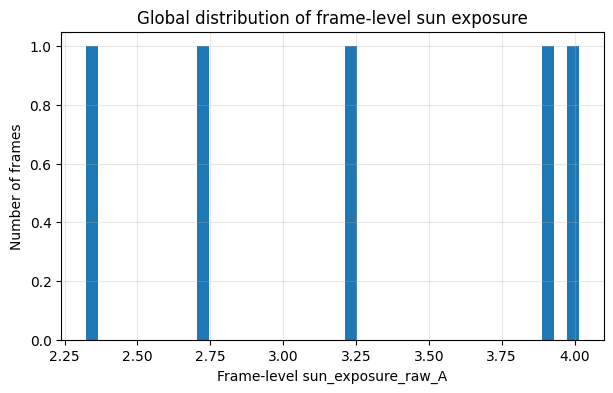

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure we don't have NaNs
frame_vals = df_sun_frames["sun_exposure_raw_A"].dropna()

plt.figure(figsize=(7, 4))
plt.hist(frame_vals, bins=40)
plt.xlabel("Frame-level sun_exposure_raw_A")
plt.ylabel("Number of frames")
plt.title("Global distribution of frame-level sun exposure")
plt.grid(True, alpha=0.3)
plt.show()


<Figure size 1000x500 with 0 Axes>

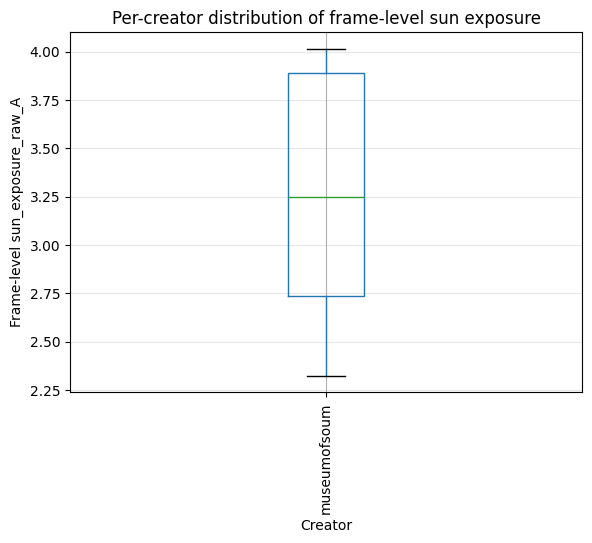

In [ ]:
# Order creators by median frame-level sun exposure
creator_medians = (
    df_sun_frames.groupby("creator")["sun_exposure_raw_A"]
    .median()
    .sort_values()
)
ordered_creators = creator_medians.index.tolist()

df_sun_frames_sorted = (
    df_sun_frames
    .set_index("creator")
    .loc[ordered_creators]
    .reset_index()
)

plt.figure(figsize=(max(10, len(ordered_creators) * 0.4), 5))
df_sun_frames_sorted.boxplot(
    column="sun_exposure_raw_A",
    by="creator",
    showfliers=False,
)
plt.xticks(rotation=90)
plt.xlabel("Creator")
plt.ylabel("Frame-level sun_exposure_raw_A")
plt.title("Per-creator distribution of frame-level sun exposure")
plt.suptitle("")  # suppress pandas' default super-title
plt.grid(True, axis="y", alpha=0.3)
plt.show()
